In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp
import datetime
import matplotlib.ticker as plticker

from sys import platform

if platform == "darwin":
    folder="/Users/sjha/Documents/Github/new_model_data/"  ## mac
if platform == "win32":
    folder="C:\\Users\\jhash\\Documents\\renders\\opto\\" ## windows

print(folder)


C:\Users\jhash\Documents\renders\opto\


In [23]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

# label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


In [3]:
def full_ODE(t,z,g_z0,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,a_0,a_p1,a_m1,a_0_d,a_p1_d,a_m1_d=z
    n_0=a_0_d*a_0
    sigma_m=1j*(a_0_d*(a_p1-a_m1)-a_0*(a_p1_d-a_m1_d))
    N_eff=g_z1*(a_p1*a_p1_d+a_m1*a_m1_d)+g_z0*n_0
    q_y_dot     =p_y
    p_y_dot     =-q_y-g_y*sigma_m*N0
    
    q_z_dot     =p_z
    p_z_dot     =-q_z-2*N_eff*N0

    a_0_dot=-1j*(del_omega+g_z0*q_z)*a_0+g_y*q_y*(a_p1-a_m1)/2
    a_p1_dot=-1j*g_z1*q_z*a_p1-g_y*q_y*a_0/2
    a_m1_dot=-1j*g_z1*q_z*a_m1+g_y*q_y*a_0/2
    
    a_0_d_dot=1j*(del_omega+g_z0*q_z)*a_0_d+g_y*q_y*(a_p1_d-a_m1_d)/2
    a_p1_d_dot=1j*g_z1*q_z*a_p1_d-g_y*q_y*a_0_d/2
    a_m1_d_dot=1j*g_z1*q_z*a_m1_d+g_y*q_y*a_0_d/2
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,a_0_dot,a_p1_dot,a_m1_dot,a_0_d_dot,a_p1_d_dot,a_m1_d_dot]
    return x_list


    
def full_evolve(x_0,a,tf,param_list,N_step=300,method="DOP853"):
    q_z_0,p_z_0,q_y_0,p_y_0=x_0
    g_z0,g_z1,g_y, del_omega, N0=param_list
    z0=np.array([q_z_0,p_z_0,q_y_0,p_y_0,a[0],a[1],a[-1],a[0].conj(),a[1].conj(),a[-1].conj()])
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(full_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-10, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3])) )
    n_0=zz[4]*zz[7]
    n_p1=zz[5]*zz[8]
    n_m1=zz[6]*zz[9]
    N=n_0+n_p1+n_m1
    sigma_m=1j*(zz[7]*(zz[5]-zz[6])-zz[4]*(zz[8]-zz[9]))
    sol.extend( (1-np.real(n_0),np.real(n_p1),np.real(N),np.real(sigma_m)) )
    return sol,t

def Pc(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    delta=del_omega-2*N0*g_z1*(g_z0-g_z1)+g_z0**2-g_z1**2
    #Pc=g_y**2*N_0/delta
    Pc=(8*delta*g_y**2*N0)/(1-delta**2)**2
    return Pc


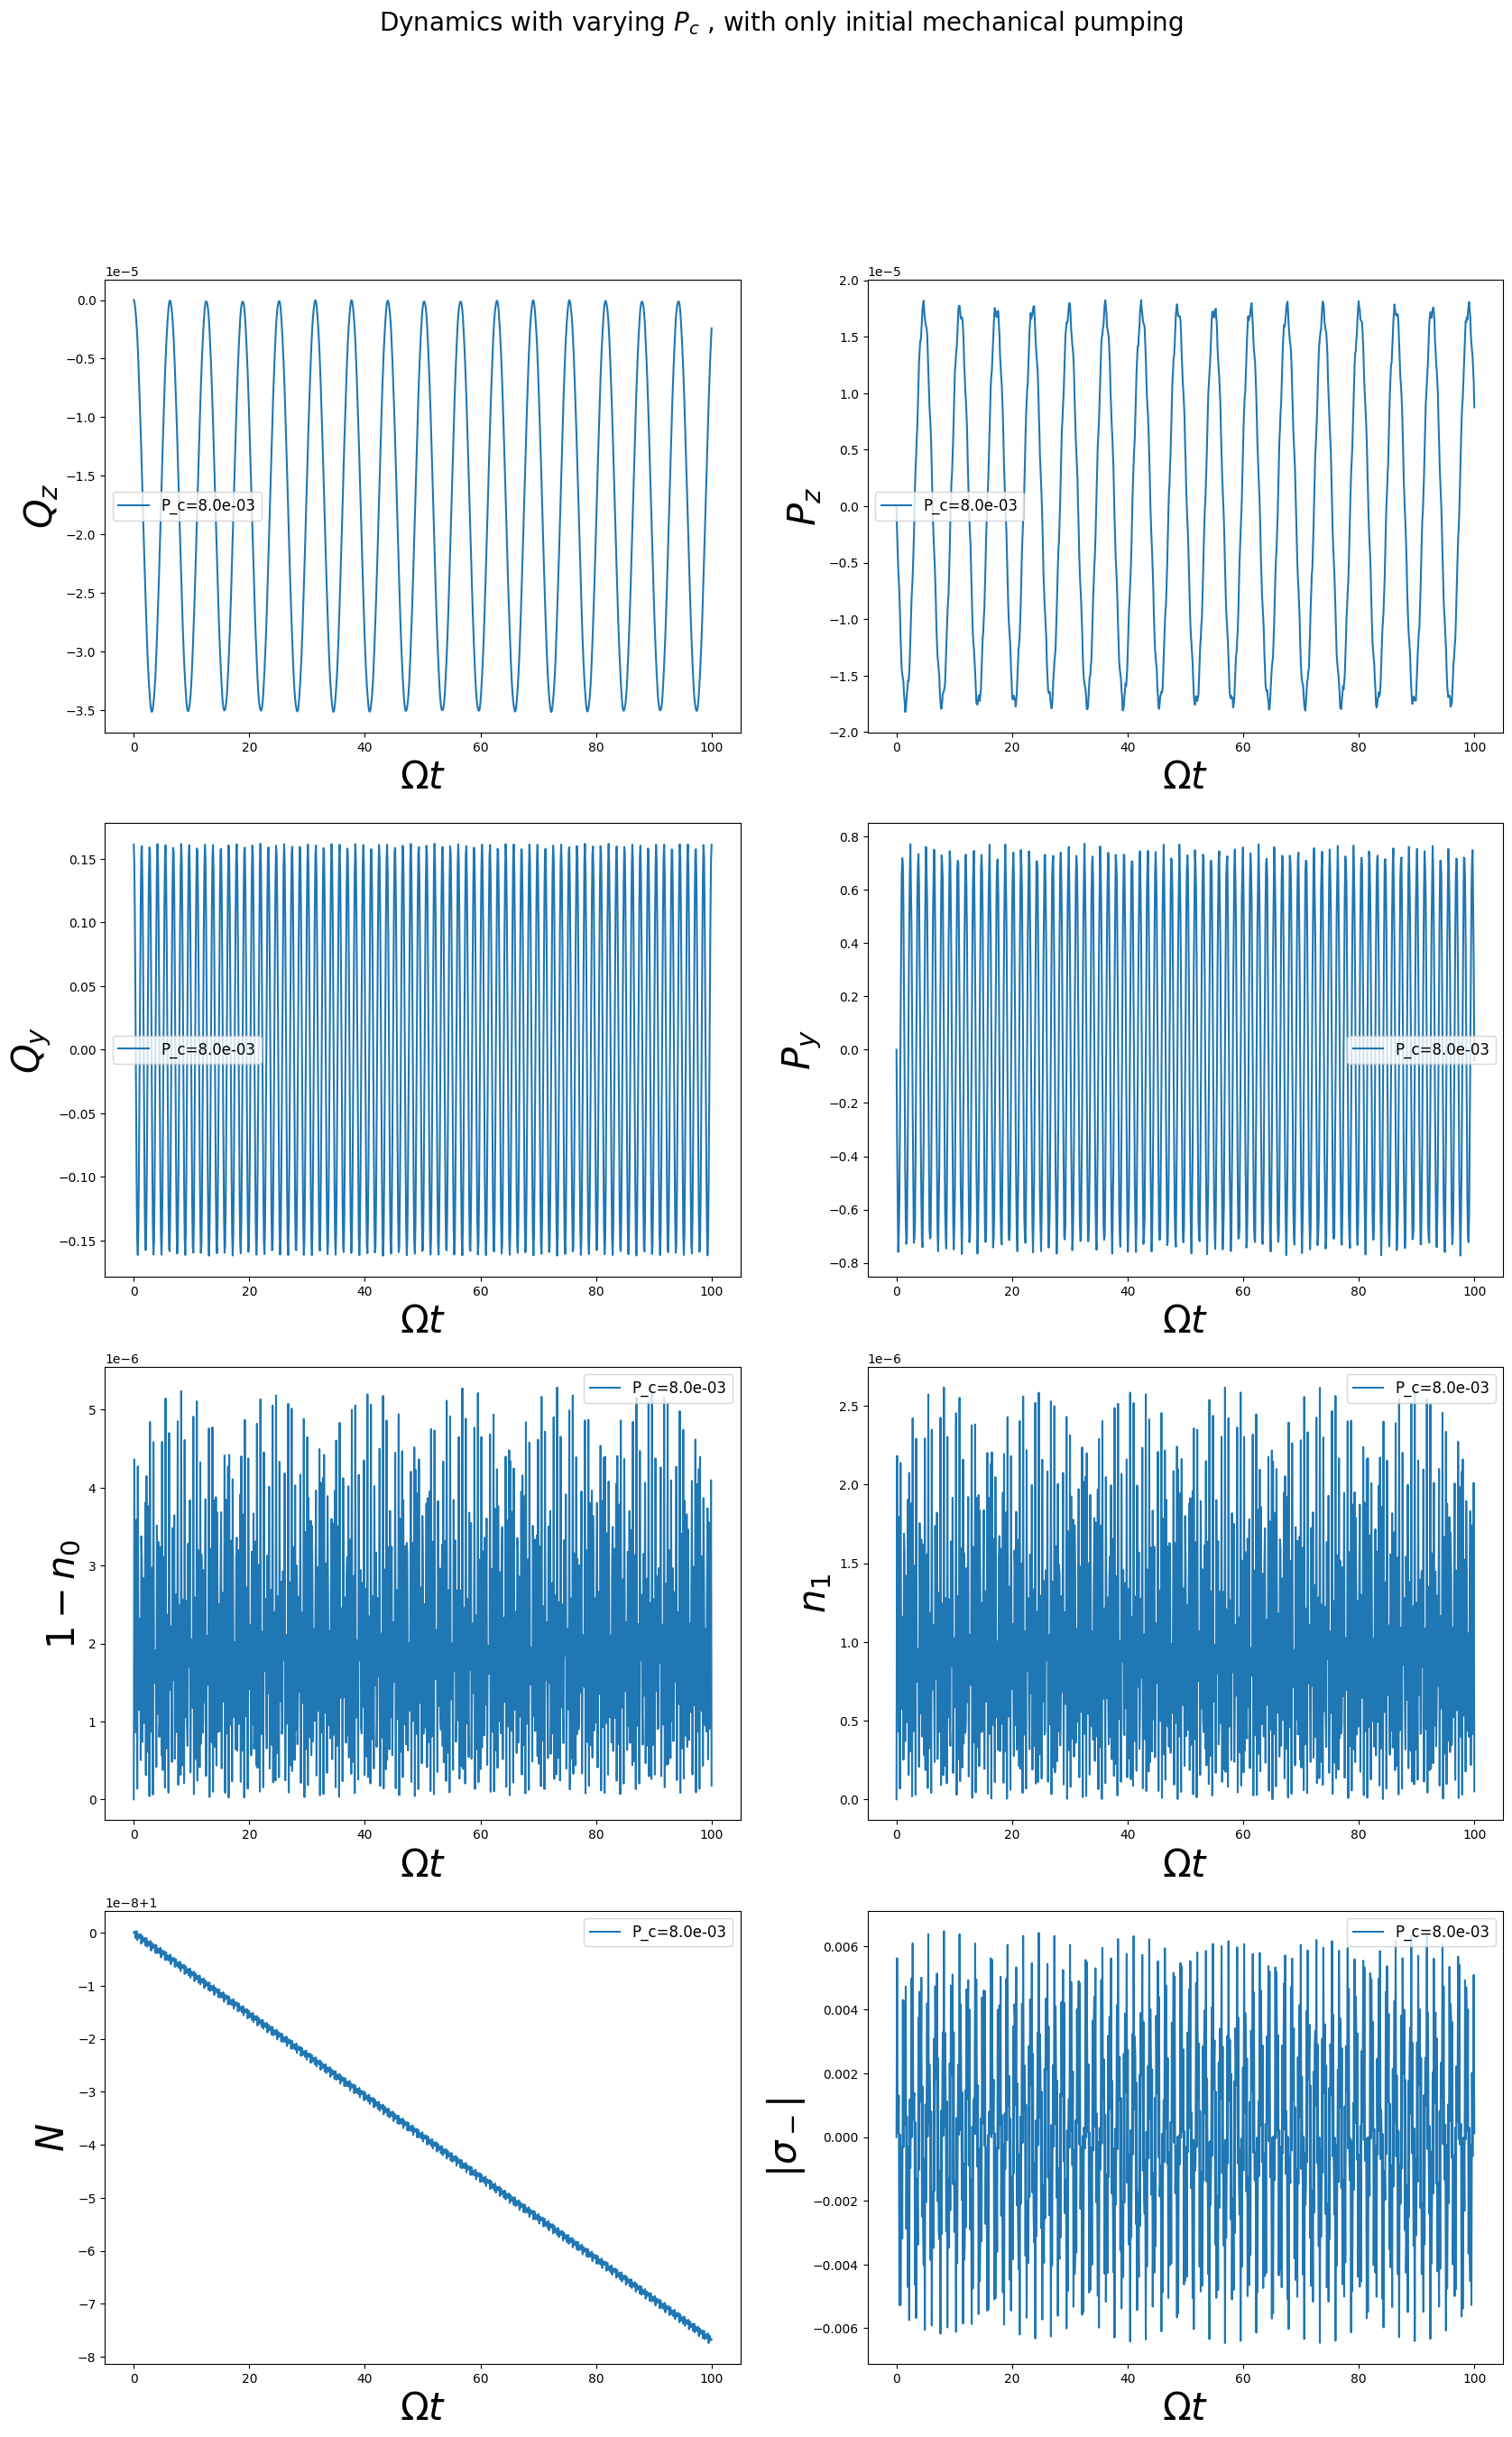

In [48]:
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$1-n_0$","$n_1$","$N$","$|\sigma_-|$"]

tf=1e2
N_step=1000
g_y=1e0
fig, axs = plt.subplots(4, 2,figsize=(20,30))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
N0_list=[1000]
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=full_evolve(x_0,psi_0,tf,param_list,N_step)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [15]:
def real_ODE(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m,E_opt_0,E_opt_1,E_mech_z,E_mech_y,E_c=z

    sigma_m=2*(A1_p*A0_m-A1_m*(A0_p+1))
    q_y_dot=p_y
    p_y_dot=-q_y-g_y*N0*sigma_m
    
    q_z_dot=p_z
#     p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
    p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)


    A1_p_dot=-(del_omega-g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
    A1_m_dot=+(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m

    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    E_c_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*(-g_z1*q_z)+g_y*q_y*N0*(A1_p_dot*A0_m+A1_p*A0_m_dot-A1_m_dot*(A0_p+1)-A1_m*A0_p_dot)-N0*g_z1*(2*A0_p+A0_p**2+A0_m**2)*q_z_dot+g_y*q_y_dot*N0*(A1_p*A0_m-A1_m*(A0_p+1))
    E_mech_dot=(q_y*q_y_dot+p_y*p_y_dot+q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_z_dot=(q_z*q_z_dot+p_z*p_z_dot)/2
    E_mech_y_dot=(q_y*q_y_dot+p_y*p_y_dot)/2
    E_opt_0_dot=2*N0*(A0_p_dot*(A0_p+1)+A0_m_dot*A0_m)*omega_0
    E_opt_1_dot=N0*(A1_p_dot*A1_p+A1_m_dot*A1_m)*omega_1
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot,E_opt_0_dot,E_opt_1_dot,E_mech_z_dot,E_mech_y_dot,E_c_dot]
    return x_list

    
def real_evolve(z0,tf,param_list,N_step=300,method="DOP853"):
    
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(real_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-10, t_eval=t,method=method)
    zz=xx.y
    sol=[]
    for i in range(np.shape(zz)[0]):
        sol.append(np.real(zz[i]))
    return sol,t



N0= 1562499.9999999998


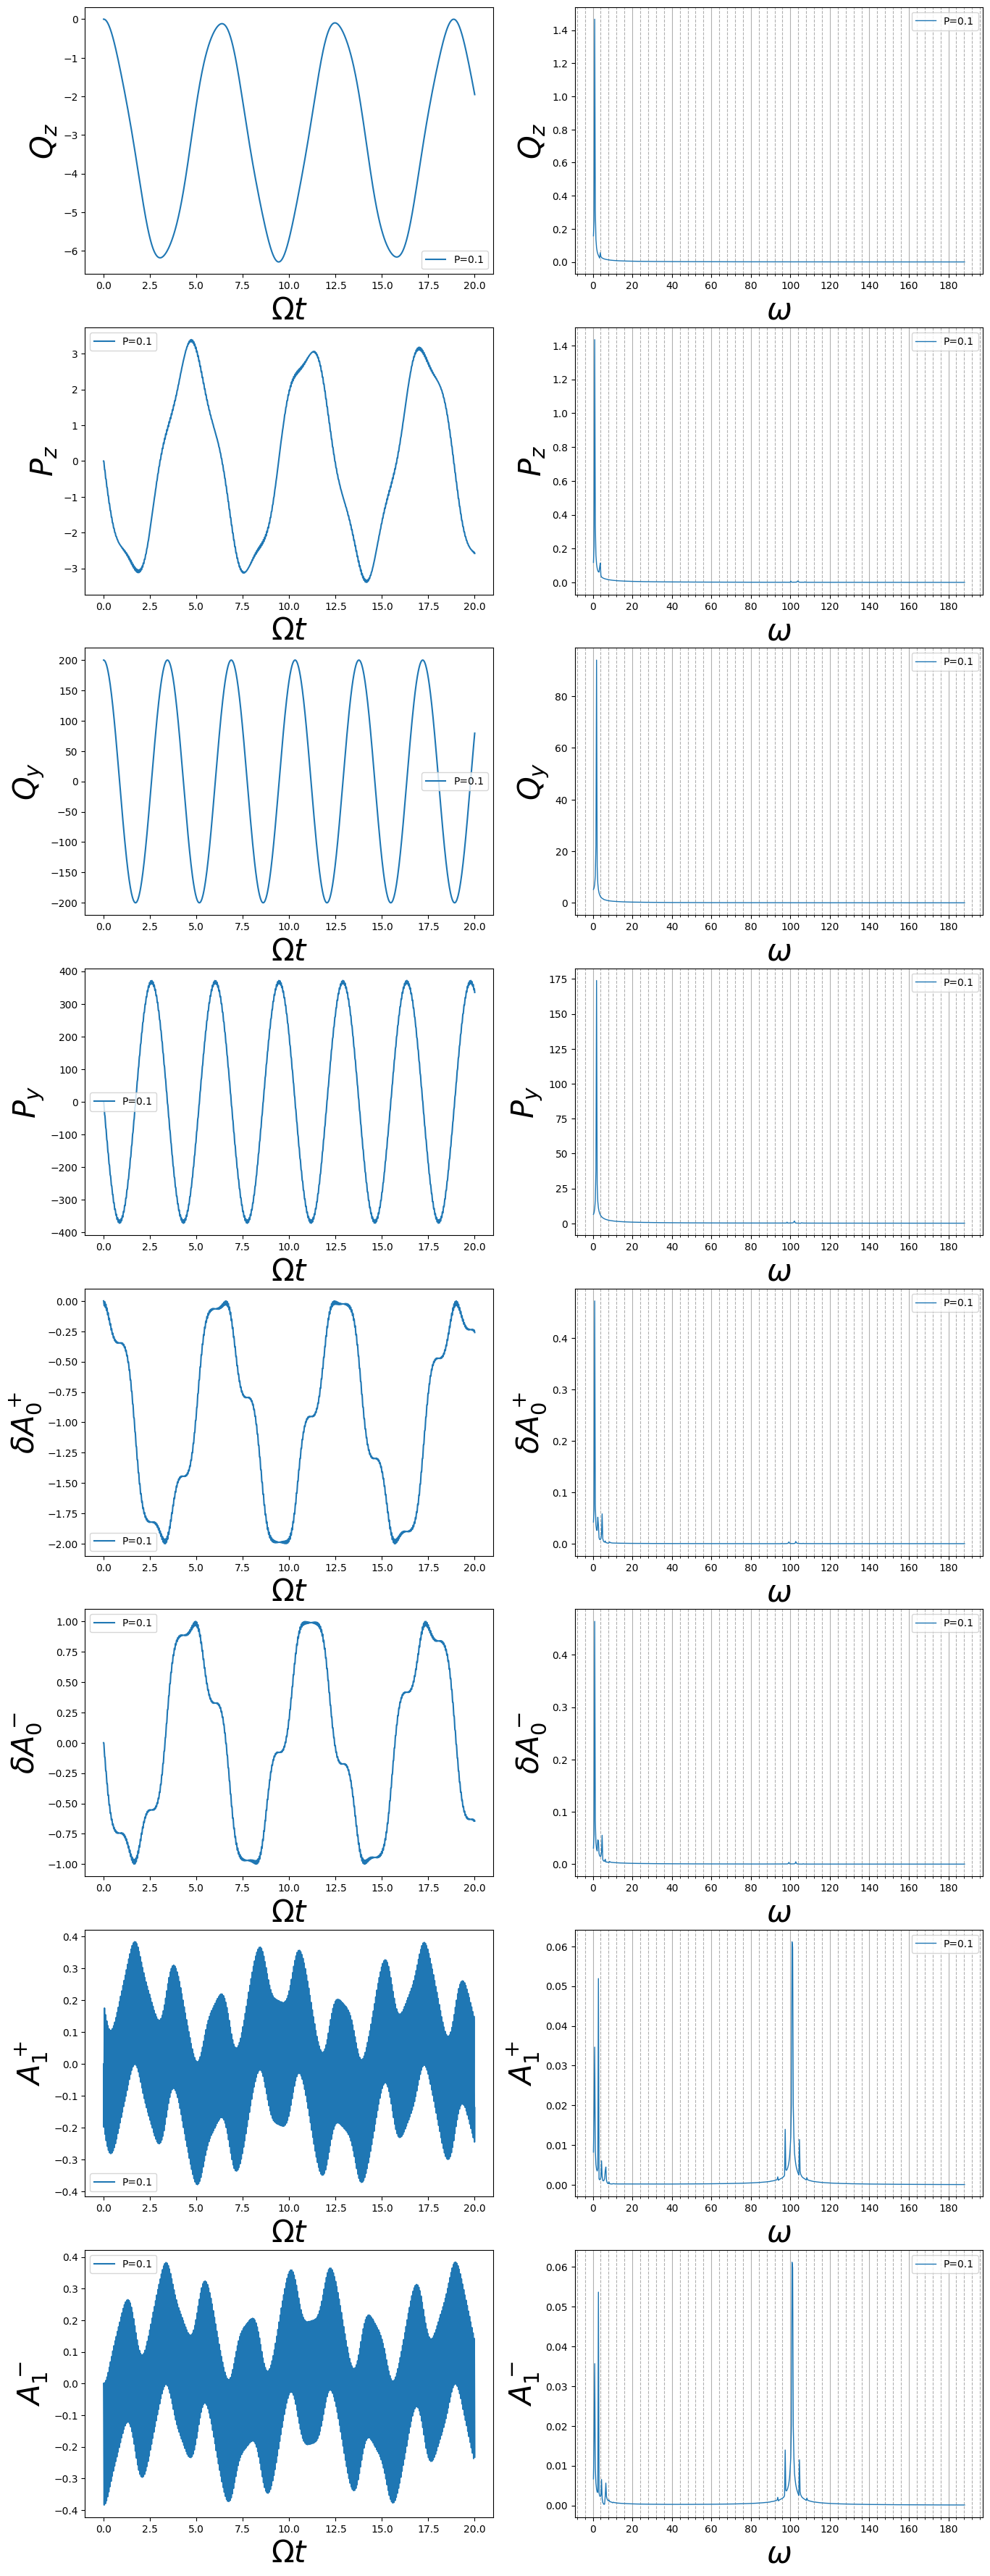

In [31]:
# g_z1=0############ 
P_list=np.array([0.1]) ############### CRITICAL parameter
g_y=1e-1
print("N0=",N0)
# title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

# D=((1-del_omega**2)**2-P**3*del_omega**4)**0.5
# print(D)
# lp=(1-del_omega**2+D)/(2*del_omega*g_y)
# lm=(1-del_omega**2-D)/(2*del_omega*g_y)
# print("lam=",lp," nu=",lm)
tf=2e1
N_step=10000
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
qy_0=200
h=N0*del_omega+qy_0**2/4
# z_0=np.array([0,0,qy_0,0,0,0,0,0,1,h])
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0],dtype=complex)  ### 0 mode excitation
# z_0=np.array([0,0,qy_0,0,0,0,0,qy_0/lp, N0*del_omega,0,0, qy_0**2/4,0])  ### lam_plus mode excitation
# z_0=np.array([0,0,qy_0,0,0,0,0,qy_0/lm, N0*del_omega,0,0, qy_0**2/4,0])  ### lam_minus mode excitation
sf,ef=1,600
om=2*np.pi*np.arange(N_step//2+1)[sf:ef]/tf

i=7
fig, axs = plt.subplots(8, 2,figsize=(16,45))

for P in (P_list):
    N0=(P*del_omega)**3/(8*g_y**2)
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=real_evolve(z_0,tf,param_list,N_step)

    for i in range(8):
        axs[i,0].plot(t,zz[i],label="P={0}".format(P))
#         zff=np.log(np.abs(np.fft.rfft(zz[i]))/N_step)
        zff=(np.abs(np.fft.rfft(zz[i]))/N_step)
        axs[i,1].plot(om,zff[sf:ef],label="P={0}".format(P),linewidth=1)

for i in range(8):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend()

    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\omega$',fontsize=30)
    axs[i,1].legend()
    axs[i,1].xaxis.set_major_locator(plticker.MultipleLocator(20))
    axs[i,1].xaxis.set_minor_locator(plticker.MultipleLocator(4))
    axs[i,1].grid(axis = 'x',which="major")
    axs[i,1].grid(axis = 'x',which="minor", linestyle='--')
    #     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

N0= 12499.999999999998
9993.998248949216
lam= -0.25008755253920756  nu= -999.6499124474609


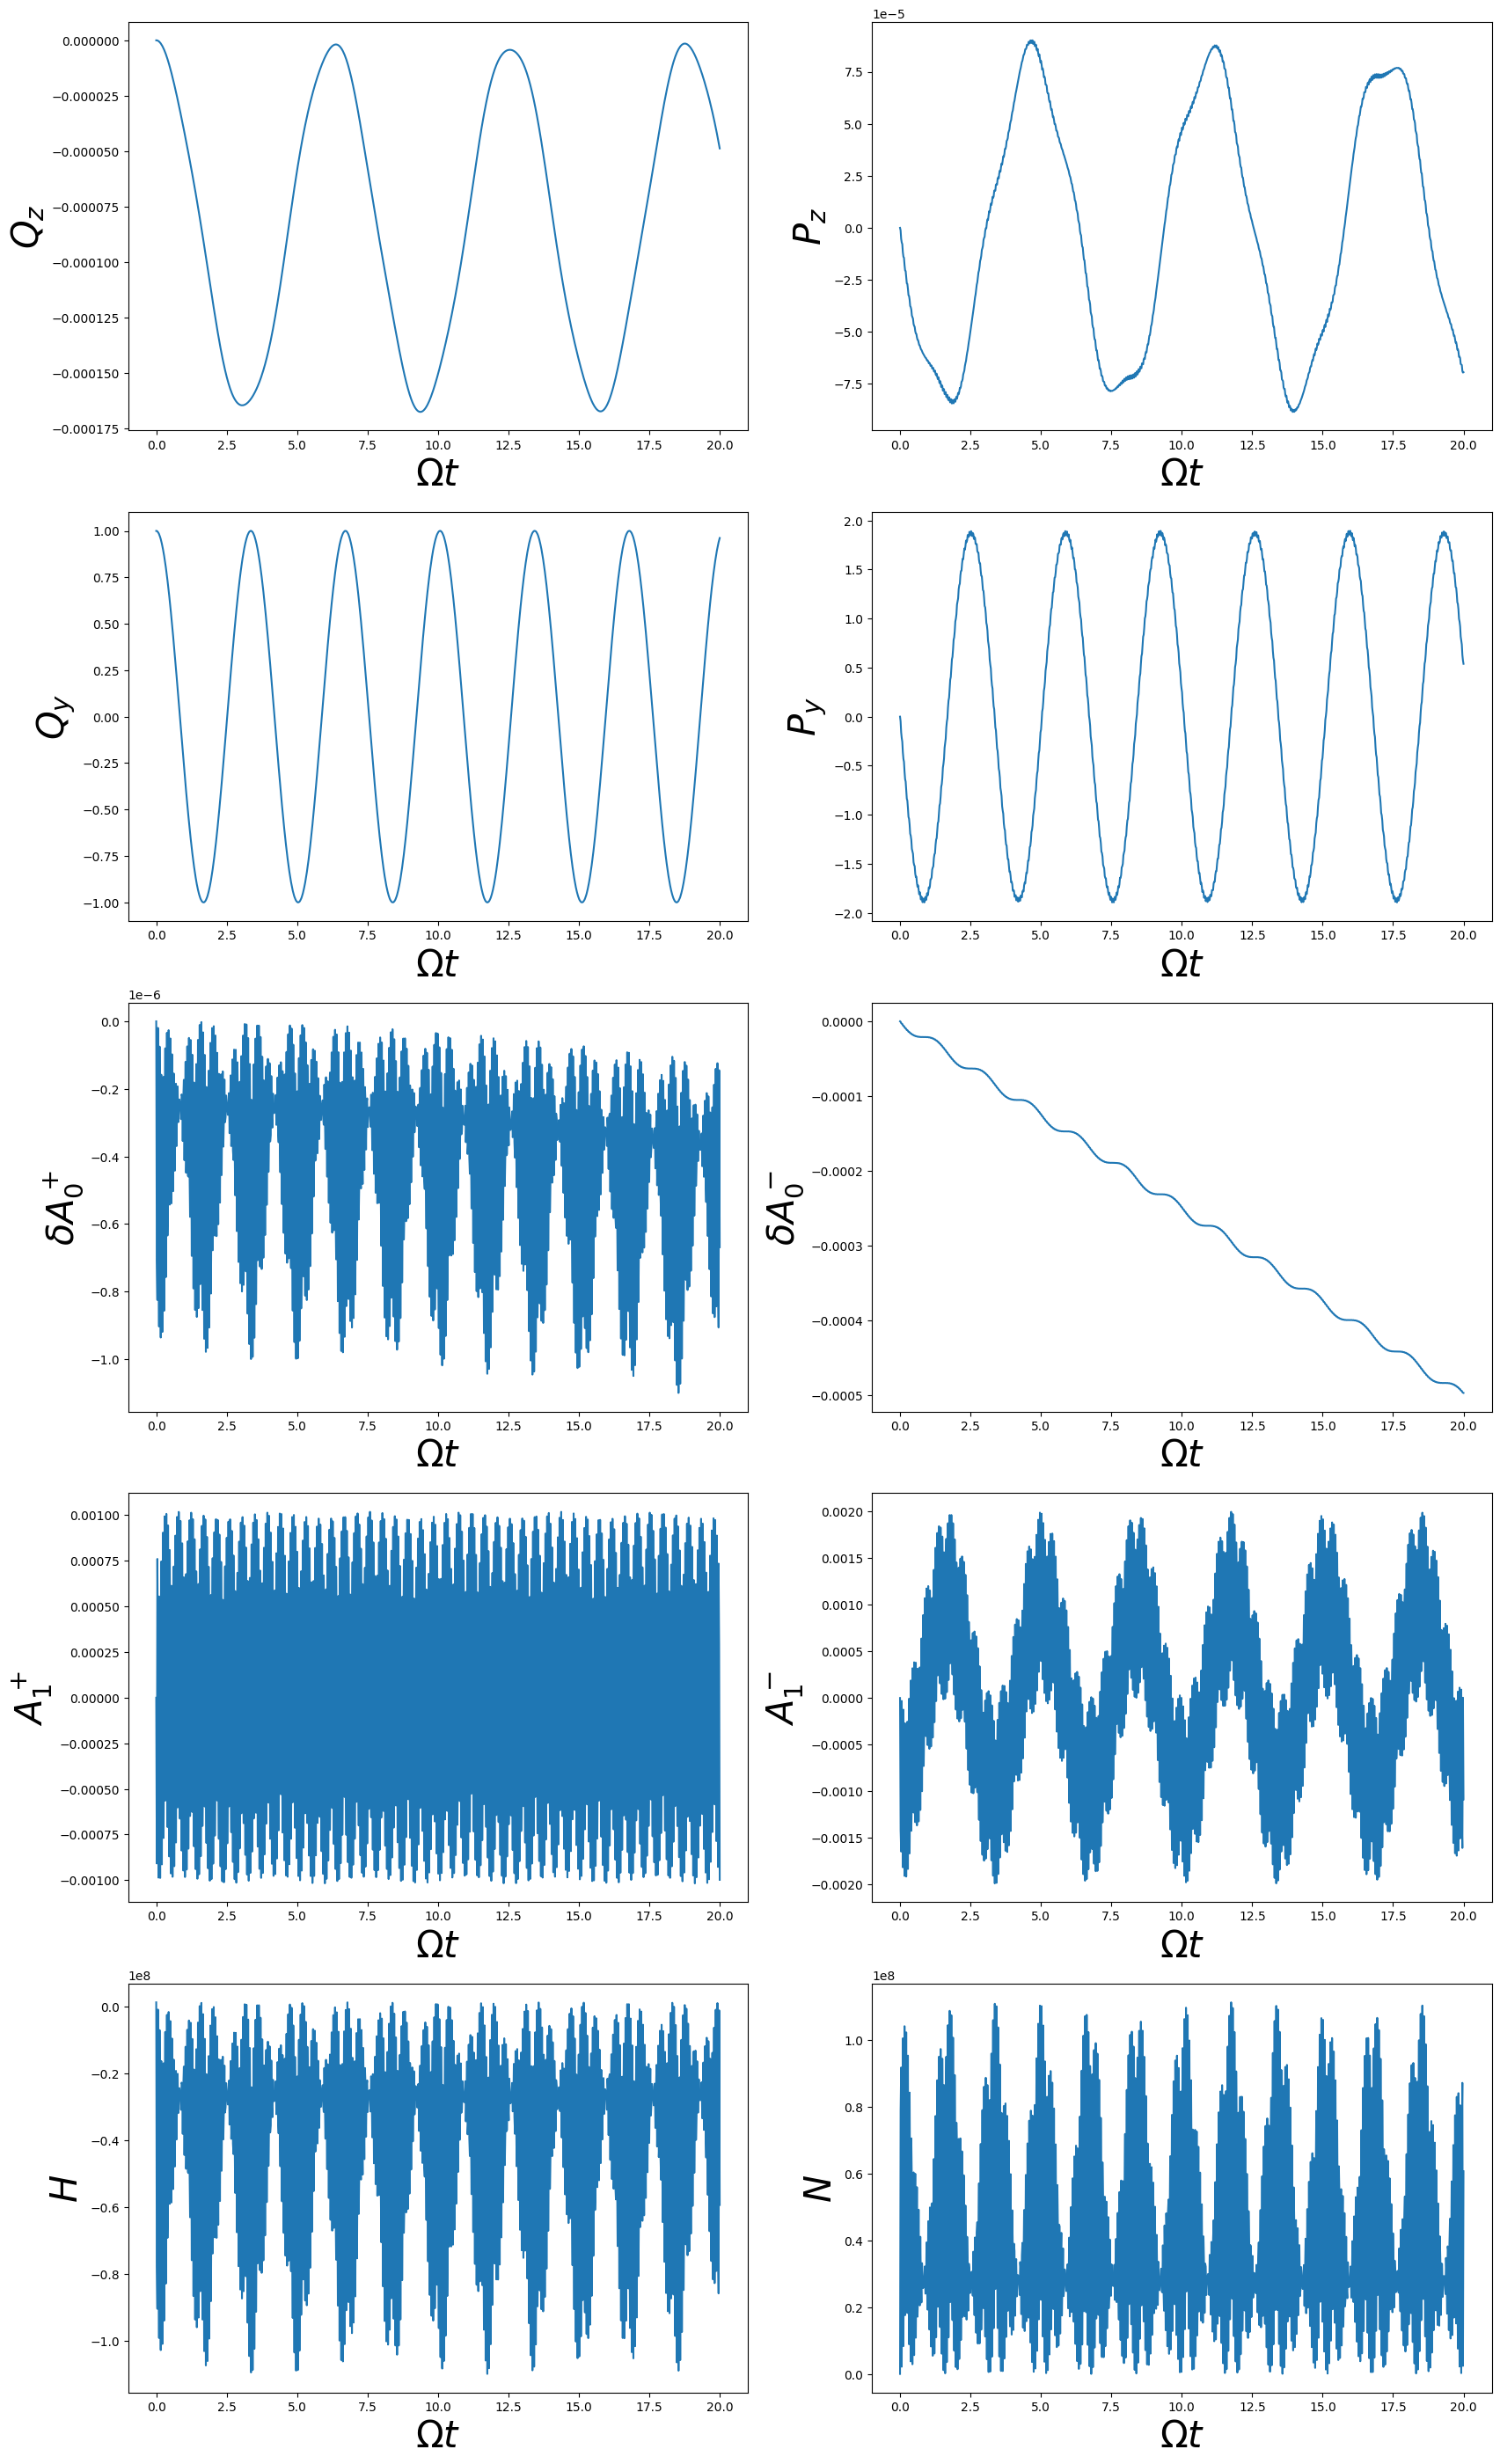

In [28]:
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

D=((1-del_omega**2)**2-P**3*del_omega**4)**0.5
print(D)
lp=(1-del_omega**2+D)/(2*del_omega*g_y)
lm=(1-del_omega**2-D)/(2*del_omega*g_y)
print("lam=",lp," nu=",lm)
tf=2e1
N_step=1000
fig, axs = plt.subplots(5, 2,figsize=(20,35))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
N0_list=[N0]
qy_0=1e0
h=N0*del_omega+qy_0**2/4
# z_0=np.array([0,0,qy_0,0,0,0,0,0,1,h])
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])  ### 0 mode excitation
# z_0=np.array([0,0,qy_0,0,0,0,0,qy_0/lp, N0*del_omega,0,0, qy_0**2/4,0])  ### lam_plus mode excitation
# z_0=np.array([0,0,qy_0,0,0,0,0,qy_0/lm, N0*del_omega,0,0, qy_0**2/4,0])  ### lam_minus mode excitation

for N0 in (N0_list):
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=real_evolve(z_0,tf,param_list,N_step)
    for i in range(10):
        axs[i//2,i%2].plot(t,zz[i])
for i in range(10):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [61]:
def psi_evol(z0,tf,param_list,N_step=300,method="DOP853"):
    
    def eig_to_real(zz):
        temp=np.array(zz,dtype=complex)
        N_step=len(zz[0])
        yy=[]
        for i in range(N_step):
#             if i==0:print(U@zz[:4,i])
#             yy.append(U@zz[:4,i])
            yy.append(np.einsum("ij,j",U,zz[:4,i]))
        temp[:4]=np.array(yy).T
        return temp 
    
    def energy(yy):
        q_y,p_y,A1_p,A1_m,A0_p,A0_m,q_z,p_z=yy[:8]        
        sigma_m=2*(A1_p*A0_m-A1_m*(A0_p+1))
        E=N0*(2*A0_p+A0_p**2+A0_m**2)*(del_omega-g_z1*q_z)+g_z1*q_z*N0+(q_y**2+p_y**2+q_z**2+p_z**2)/4+q_y*g_y*N0*sigma_m/2
        return E

#     def psi_ODE_v2(t,z,delta,g_y,g_z1,N0):
#     def psi_ODE_v2(t,z,g_z1,g_y,del_omega,N0):
        
#         psi_1,psi_2,psi_3,psi_4,A0_p,A0_m,q_z,p_z,N=z
#         psi=np.array([psi_1,psi_2,psi_3,psi_4])
#         w=mat_mul(U,psi)
#         q_y,p_y,A1_p,A1_m=w
#         nl=np.array([0,-2*g_y*N0*(A1_p*A0_m-A1_m*A0_p),+g_z1*q_z*A1_m-g_y*q_y*A0_p,-g_z1*q_z*A1_p-g_y*q_y*A0_m],dtype=complex)
#         psi_dot=mat_mul(Eig,psi)+mat_mul(U_inv,nl)

#         q_z_dot=p_z
#         p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)

#         A0_p_dot=g_y*q_y*A1_p/2
#         A0_m_dot=g_y*q_y*A1_m/2

#         psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot=psi_dot
#         w_dot=mat_mul(U,psi_dot)
#         q_y_dot,p_y_dot,A1_p_dot,A1_m_dot=w_dot
#         N_dot=2*A0_p_dot+2*A0_p*A0_p_dot+2*A0_m*A0_m_dot+A1_p*A1_p_dot+A1_m*A1_m_dot

#         x_list=[psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,A0_p_dot,A0_m_dot,q_z_dot,p_z_dot,N_dot]
#         return x_list

    def psi_ODE_v1(t,z,g_z1,g_y,del_omega,N0):
        
#         tk=(100*t/tf)
#         if tk%10<1e-4:print(np.round(tk,2),"% progressed")
        psi_1,psi_2,psi_3,psi_4,A0_p,A0_m,q_z,p_z,N=z
        psi=np.array([psi_1,psi_2,psi_3,psi_4])
        w=(U@psi)
#         if t==0: print(w)
        q_y,p_y,A1_p,A1_m=w
        nl=np.array([0,-2*g_y*N0*(A1_p*A0_m-A1_m*A0_p),+g_z1*q_z*A1_m-g_y*q_y*A0_p,-g_z1*q_z*A1_p-g_y*q_y*A0_m],dtype=complex)
        psi_dot=Eig@psi+U_inv@nl

        q_z_dot=p_z
#         p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)
        p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)

        A0_p_dot=g_y*q_y*A1_p/2
        A0_m_dot=g_y*q_y*A1_m/2

        psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot=psi_dot
        w_dot=(U@psi_dot)
        q_y_dot,p_y_dot,A1_p_dot,A1_m_dot=w_dot
#         N_dot=2*((A0_p+1)*A0_p_dot+A0_m*A0_m_dot)+(A1_p*A1_p_dot+A1_m*A1_m_dot)
        N_dot=2*A0_p_dot+2*A0_p*A0_p_dot+2*A0_m*A0_m_dot+A1_p*A1_p_dot+A1_m*A1_m_dot

        x_list=[psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,A0_p_dot,A0_m_dot,q_z_dot,p_z_dot,N_dot]
        return x_list

#     delta,g_y,g_z1,N0=param_list
    g_z1,g_y,del_omega,N0=param_list
    
#     delta*=-1
    D=((1-del_omega**2)**2-8*g_y**2*N0*del_omega)**0.5
    lam=((1+del_omega**2+D)/2)**0.5
    nu=((1+del_omega**2-D)/2)**0.5
#     delta_0=(8*g_y**2*N0)**(1/3)
    
    lp=(1-del_omega**2+D)/(2*del_omega*g_y)
    lm=(1-del_omega**2-D)/(2*del_omega*g_y)
    M=np.array([
                [0,1,0,0],
                [-1,0,0,2*g_y*N0],
                [-g_y,0,0,-del_omega],
                [0,0,del_omega,0]
        ])
    U_inv=(del_omega*g_y/(2*D))*np.array([
                [1,1,-1,-1],
                [1j/lam,-1j/lam,-1j/nu,1j/nu],
                [-1j*del_omega*lm/lam,1j*del_omega*lm/lam,1j*del_omega*lp/nu,-1j*del_omega*lp/nu],
                [-lm,-lm,lp,lp]
        ]).T
#     U=np.array([
#             [lp,lp,lm,lm],
#             [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
#             [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
#             [1,1,1,1]
#     ])

    U=np.array([
                [lp,lp,lm,lm],
                [-1j*lp*lam,1j*lp*lam,-1j*lm*nu,1j*lm*nu],
                [-1j*lam/del_omega,1j*lam/del_omega,-1j*nu/del_omega,1j*nu/del_omega],
                [1,1,1,1]
    ])
    
    Eig=np.diag([-1j*lam,1j*lam,-1j*nu,1j*nu])
    print(np.allclose(M,U@Eig@U_inv))
    #print(np.trace(M,U@Eig@U_inv))
#     print(M-U@Eig@U_inv)

#     f=del_omega*g_y*(lp-lm)/D
#     print("f=",f)
#     U_inv/=f**0.5
#     U/=f**0.5
#     print(np.linalg.det(U@U_inv))
    t = np.linspace(0,tf,N_step)
    z0[:4]*=del_omega*g_y/(2*D)
#     print(z0)
#     print("########")
    xx=solve_ivp(psi_ODE_v1, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-12, t_eval=t,method=method)
    zz=xx.y
    yy=np.real(eig_to_real(zz))
    H=energy(yy)
    Num=yy[8]
    sol_real=[]
    sol_eig=[]
    sol_real.extend( (yy[6],yy[7],yy[0],yy[1],yy[4],yy[5],yy[2],yy[3]) )
    sol_eig.extend((zz[1],zz[3],zz[5],zz[7]))
#     sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3]),np.real(zz[4]),np.real(zz[5]),np.real(zz[6]),np.real(zz[7]),H,np.real(Num)) )

    return sol_real,sol_eig,t




In [62]:
def phi_stable_evol(z0,tf,param_list,N_step=300):
#     delta,g_y,g_z1,N0=param_list
    g_z1,g_y,delta,N0=param_list
    D=((1-delta**2)**2-8*g_y**2*N0*delta)**0.5
    lam=((1+delta**2+D)/2)**0.5
    nu=((1+delta**2-D)/2)**0.5
    print("lam=",lam,"nu=",nu)
    lp=(1-delta**2+D)/(2*delta*g_y)
    lm=(1-delta**2-D)/(2*delta*g_y)
    U_inv=(delta*g_y/(2*D))*np.array([
                [1,1,-1,-1],
                [1j/lam,-1j/lam,-1j/nu,1j/nu],
                [-1j*delta*lm/lam,1j*delta*lm/lam,1j*delta*lp/nu,-1j*delta*lp/nu],
                [-lm,-lm,lp,lp]
        ]).T

    U=np.array([
                [lp,lp,lm,lm],
                [-1j*lp*lam,1j*lp*lam,-1j*lm*nu,1j*lm*nu],
                [-1j*lam/delta,1j*lam/delta,-1j*nu/delta,1j*nu/delta],
                [1,1,1,1]
    ])
    Eig=np.diag([-1j*lam,1j*lam,-1j*nu,1j*nu])
    print(np.round(U@Eig@U_inv,4))
    
    def phi_to_real(zz):
        temp=np.array(zz,dtype=complex)
        N_step=len(zz[0])
        yy=[]
        for i in range(N_step):
            E=np.diag(np.exp( 1j*t_list[i]*np.array([-lam,lam,-nu,nu])))
            yy.append(np.einsum("ij,j",U@E,zz[:4,i]))
        temp[:4]=np.array(yy).T
        return temp 

#     def phi_ODE(t,z,delta,g,g_z1,N0):
    def phi_ODE(t,z,g_z1,g_y,delta,N0):
        E    =np.diag(np.exp( 1j*t*np.array([-lam,lam,-nu,nu])))
        E_inv=np.diag(np.exp(-1j*t*np.array([-lam,lam,-nu,nu])))

        phi_1,phi_1_d,phi_2,phi_2_d,A0_p,A0_m,q_z,p_z=z
        phi=np.array([phi_1,phi_1_d,phi_2,phi_2_d])
        w=U@E@phi
        q_y,p_y,A1_p,A1_m=w
        nl=np.array([0,-2*g_y*N0*(A1_p*A0_m-A1_m*A0_p),+g_z1*q_z*A1_m-g_y*q_y*A0_p,-g_z1*q_z*A1_p-g_y*q_y*A0_m],dtype=complex)
#         nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,g_z1*u_z*w[2]-g*w[0]*A_m])
        phi_dot=E_inv@U_inv@nl
    
        q_z_dot=p_z
        p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)

        A0_p_dot=g_y*q_y*A1_p/2
        A0_m_dot=g_y*q_y*A1_m/2

        phi_1_dot,phi_1_d_dot,phi_2_dot,phi_2_d_dot=phi_dot
#         w_dot=U@E@phi_dot
#         q_y_dot,p_y_dot,A1_p_dot,A1_m_dot=w_dot
#         N_dot=2*A0_p_dot+2*A0_p*A0_p_dot+2*A0_m*A0_m_dot+A1_p*A1_p_dot+A1_m*A1_m_dot

        x_list=[phi_1_dot,phi_1_d_dot,phi_2_dot,phi_2_d_dot,A0_p_dot,A0_m_dot,q_z_dot,p_z_dot]
        return x_list

    t_list = np.linspace(0,tf,N_step)
    z0[:4]*=delta*g_y/(2*D)
    xx=solve_ivp(phi_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-14, t_eval=t_list)
    zz=xx.y
    print("initial condition",np.einsum("ij,j",U,zz[0][:4]))

    yy=np.real(phi_to_real(zz))
    sol_real=[]
    sol_eig=[]
    sol_real.extend( (yy[6],yy[7],yy[0],yy[1],yy[4],yy[5],yy[2],yy[3]) )
    sol_eig.extend((zz[1],zz[3],zz[5],zz[7]))

    return sol_real,sol_eig,t_list

#### $\psi$ eigenmode simulation


N0= 12499.999999999998
True


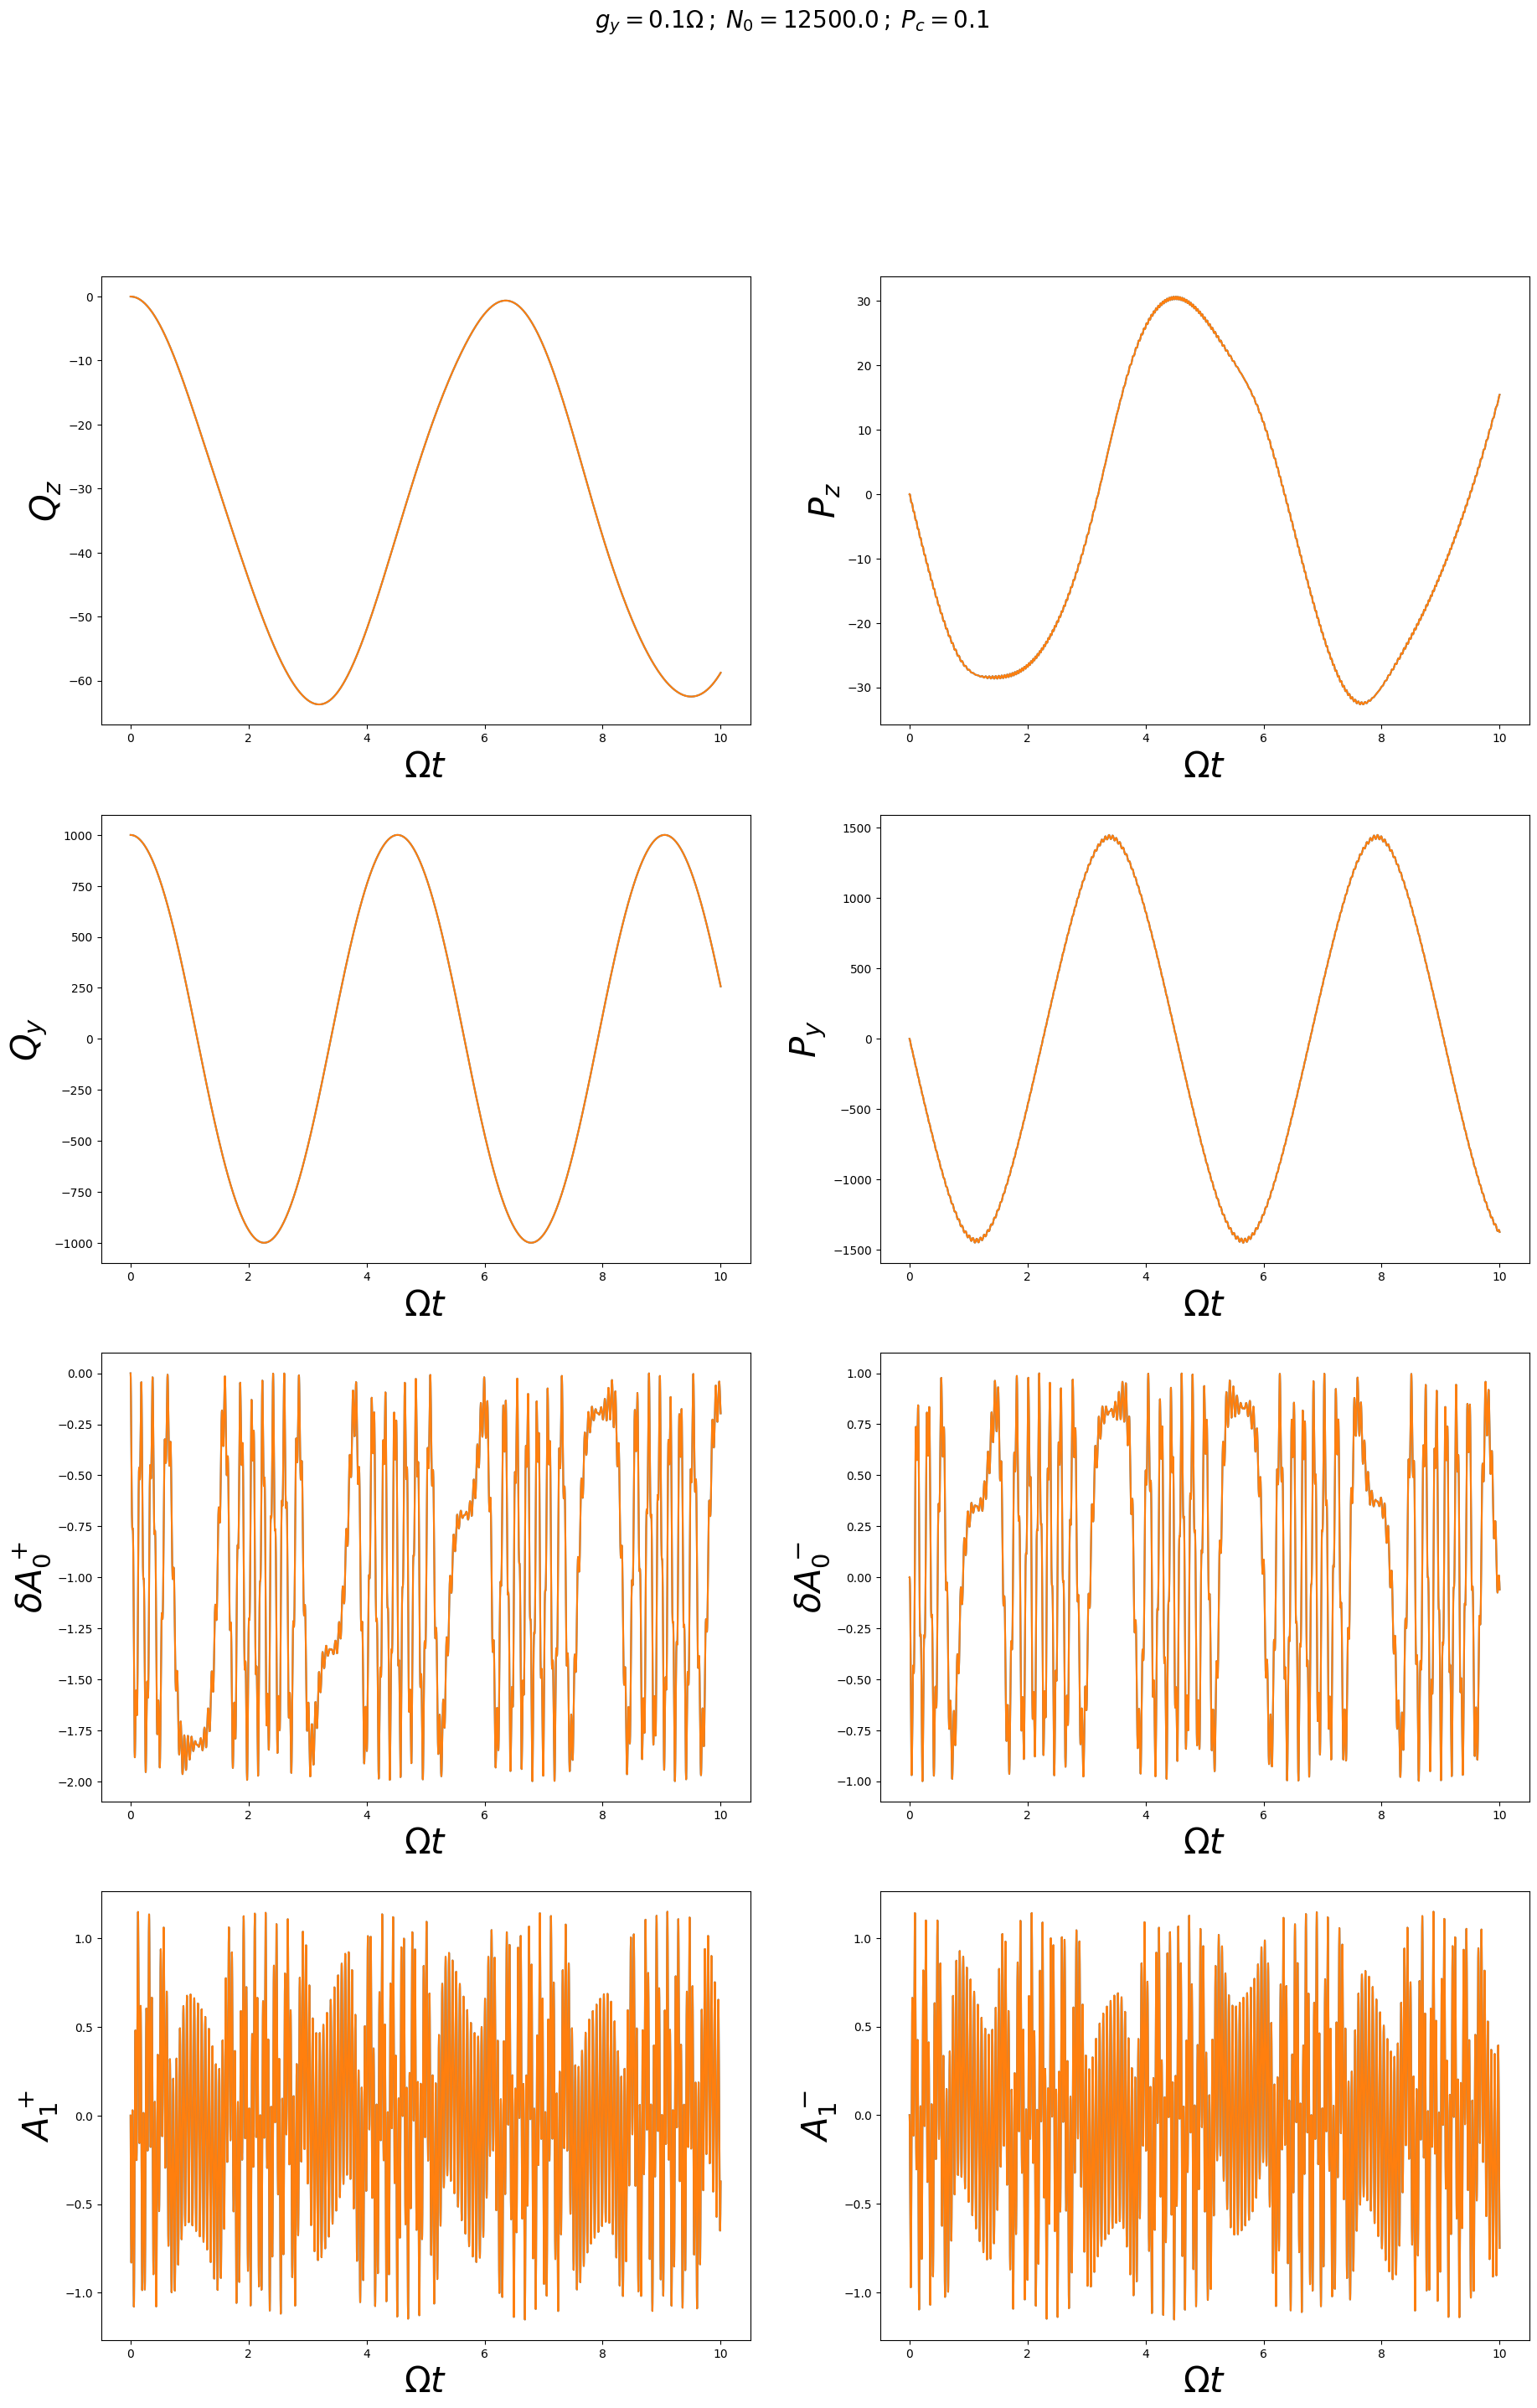

In [64]:

P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,np.round(N0),P)

tf=1e1
N_step=10000
qy_0=1e3
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])  ### 0 mode excitation

param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz1,t1=real_evolve(z_0,tf,param_list,N_step)
###########
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]
z0=np.array([1,1,-1,-1,0,0,0,0,0])*qy_0+0j
z0[8]=1

zz2,_,t2=psi_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
fig.suptitle(title, fontsize=20)
for i in range(8):
#     axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].plot(t1,zz1[i],t2,zz2[i])
#     axs[i//2,i%2].plot(t1,(zz1[i]-zz2[i])/np.max(np.abs(zz1[i])))
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

N0= 12499.999999999998
lam= 99.98749484047796 nu= 1.871062672759006
[[ 0.0e+00+0.j  1.0e+00+0.j -0.0e+00+0.j  0.0e+00+0.j]
 [-1.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  2.5e+03+0.j]
 [-1.0e-01+0.j  0.0e+00+0.j  0.0e+00+0.j -1.0e+02+0.j]
 [ 0.0e+00+0.j -0.0e+00+0.j  1.0e+02+0.j  0.0e+00+0.j]]
initial condition [-1.00029984e+03-1.43884985e+00j  1.45413545e+00+2.51132220e-01j
 -5.61527037e-05-4.59419774e-06j  2.00099828e+00+1.48096521e-03j]


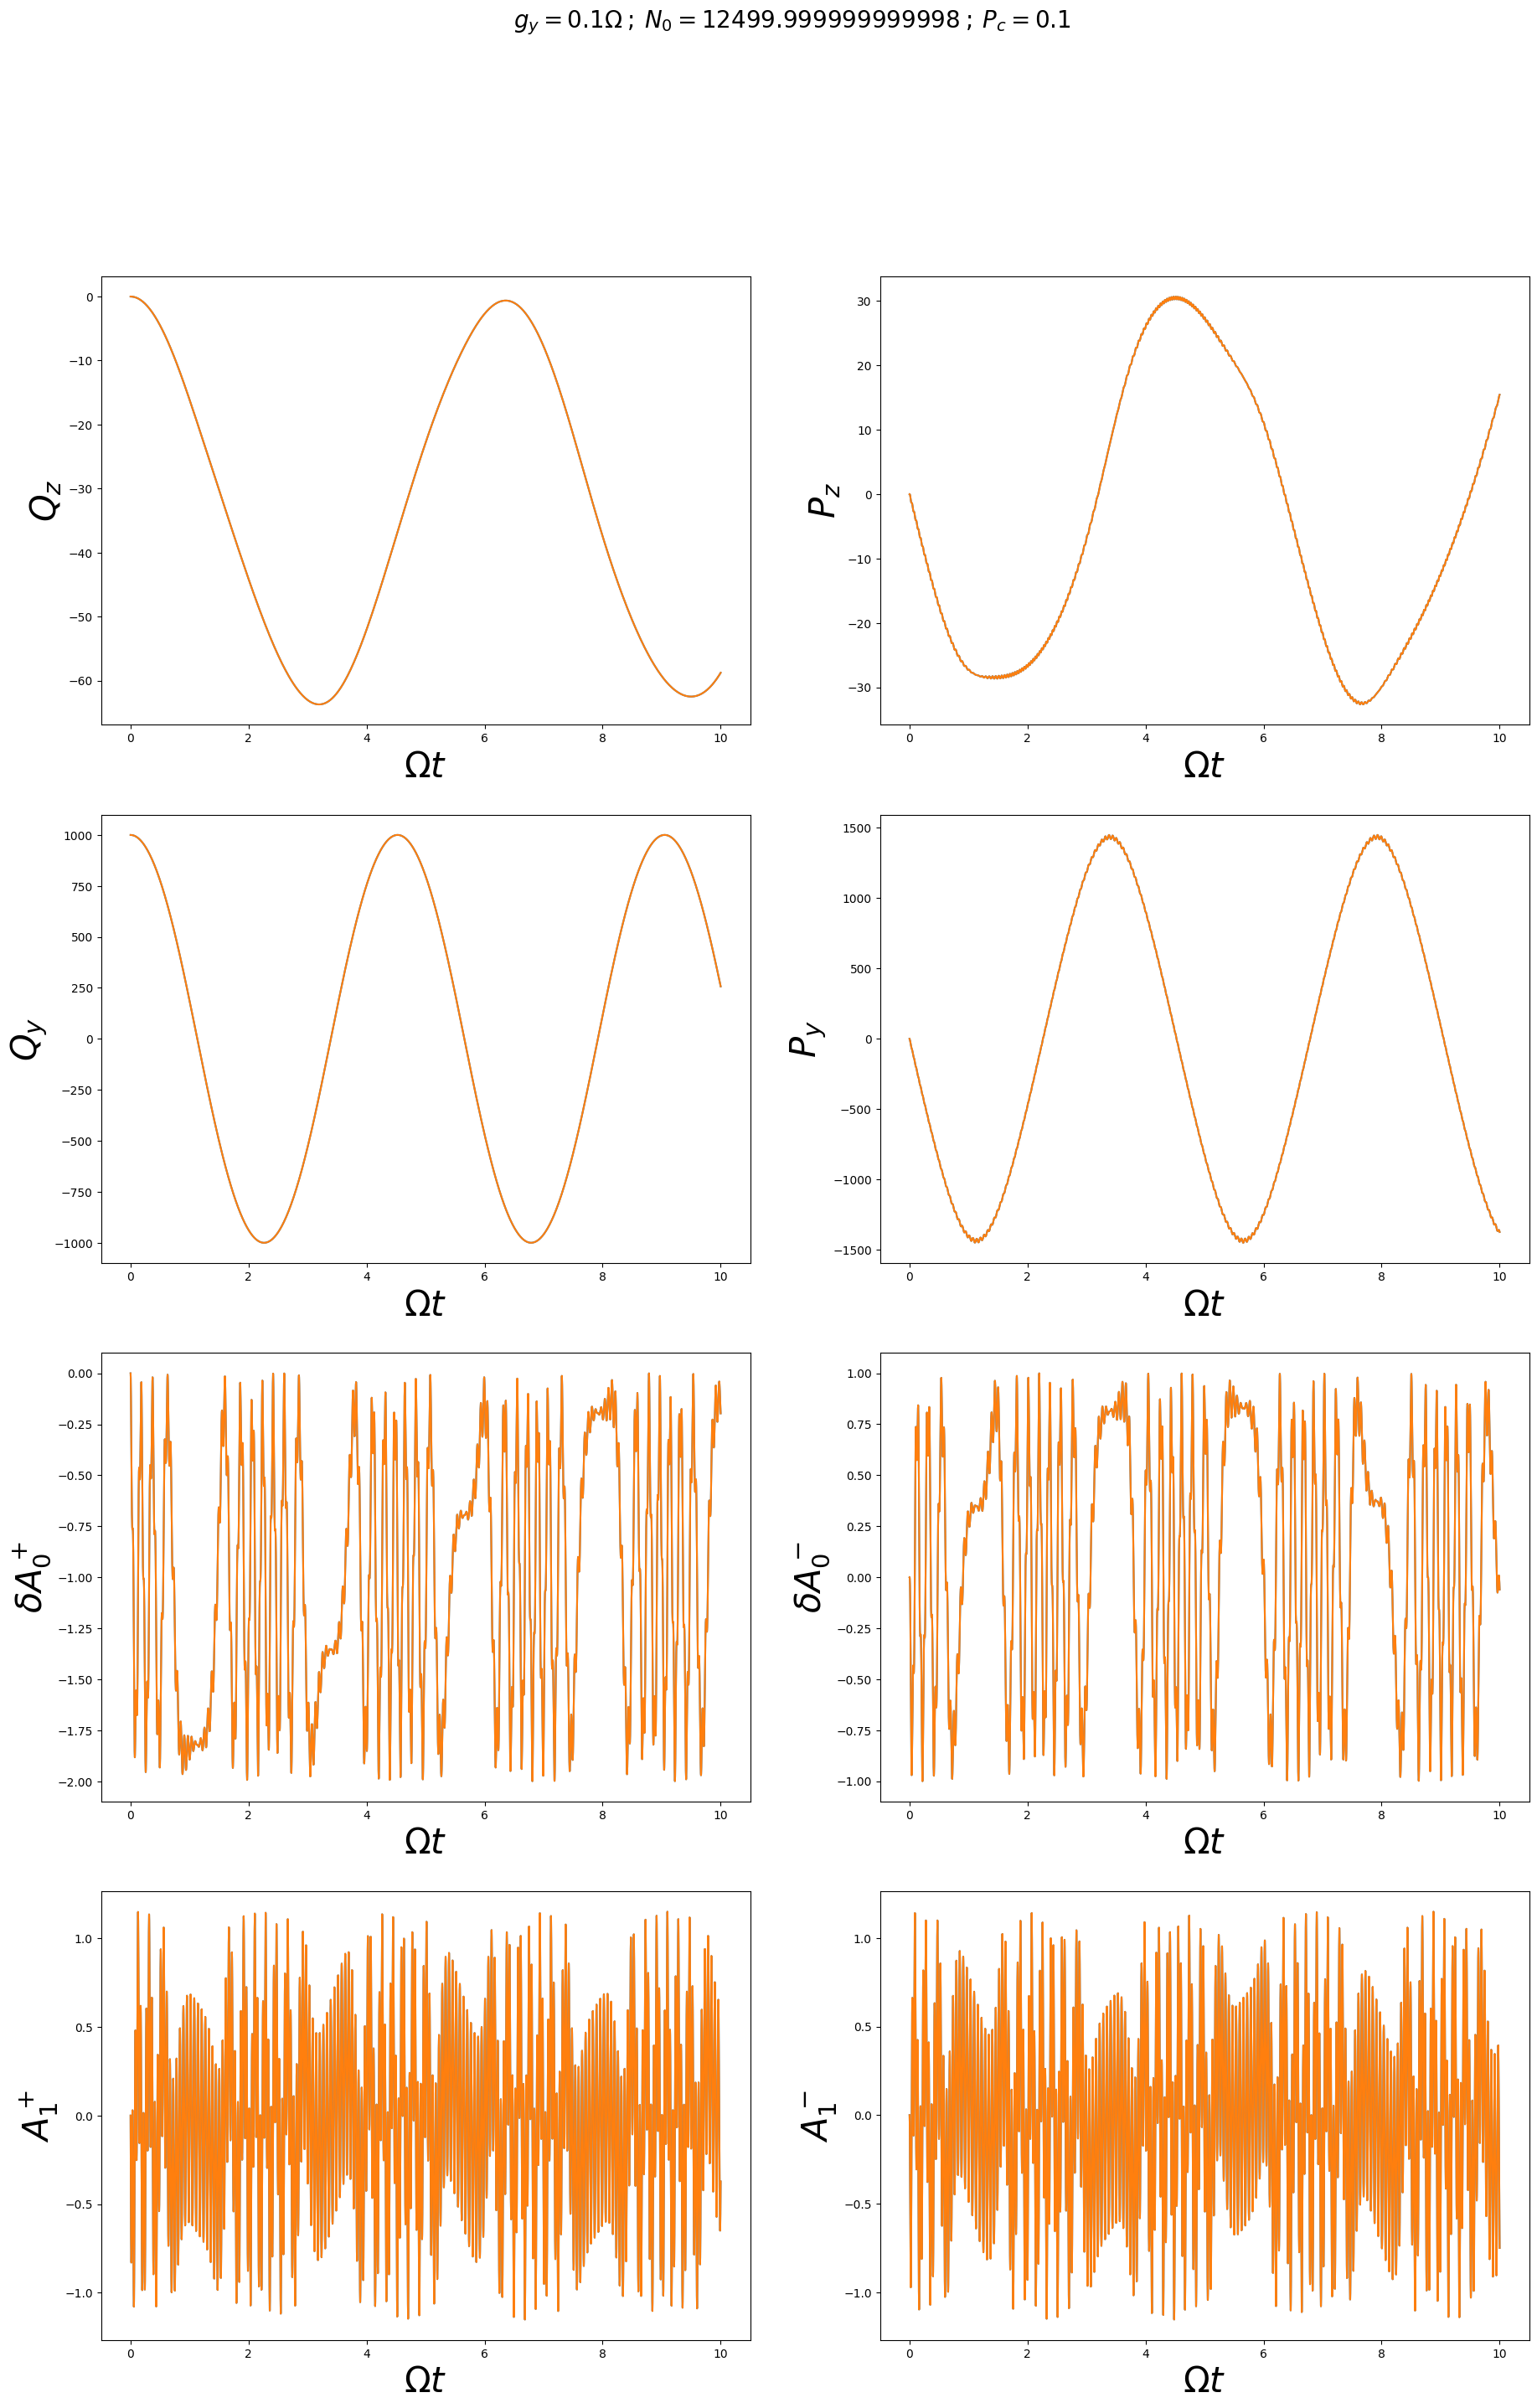

In [65]:
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

tf=1e1
N_step=10000
N0_list=[N0]
qy_0=1000
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])  ### 0 mode excitation

param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz1,t1=real_evolve(z_0,tf,param_list,N_step)
###########

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]
z0=np.array([1,1,-1,-1,0,0,0,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function


# param_list=[del_omega,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz2,_,t2=phi_stable_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
fig.suptitle(title, fontsize=20)
for i in range(8):
#     axs[i//2,i%2].plot(t1,(zz1[i]-zz2[i])/np.max(np.abs(zz1[i])))
    axs[i//2,i%2].plot(t1,zz1[i],t2,zz2[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

lam= 99.98749484047796 nu= 1.871062672759006
[[ 0.0e+00+0.j  1.0e+00+0.j -0.0e+00+0.j  0.0e+00+0.j]
 [-1.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  2.5e+03+0.j]
 [-1.0e-01+0.j  0.0e+00+0.j  0.0e+00+0.j -1.0e+02+0.j]
 [ 0.0e+00+0.j -0.0e+00+0.j  1.0e+02+0.j  0.0e+00+0.j]]
initial condition [-3.00144715e+02-3.89184459e-02j  3.93612286e-02+6.79639191e-03j
 -1.51737474e-06-1.24214409e-07j  6.00354836e-01+4.00558407e-05j]


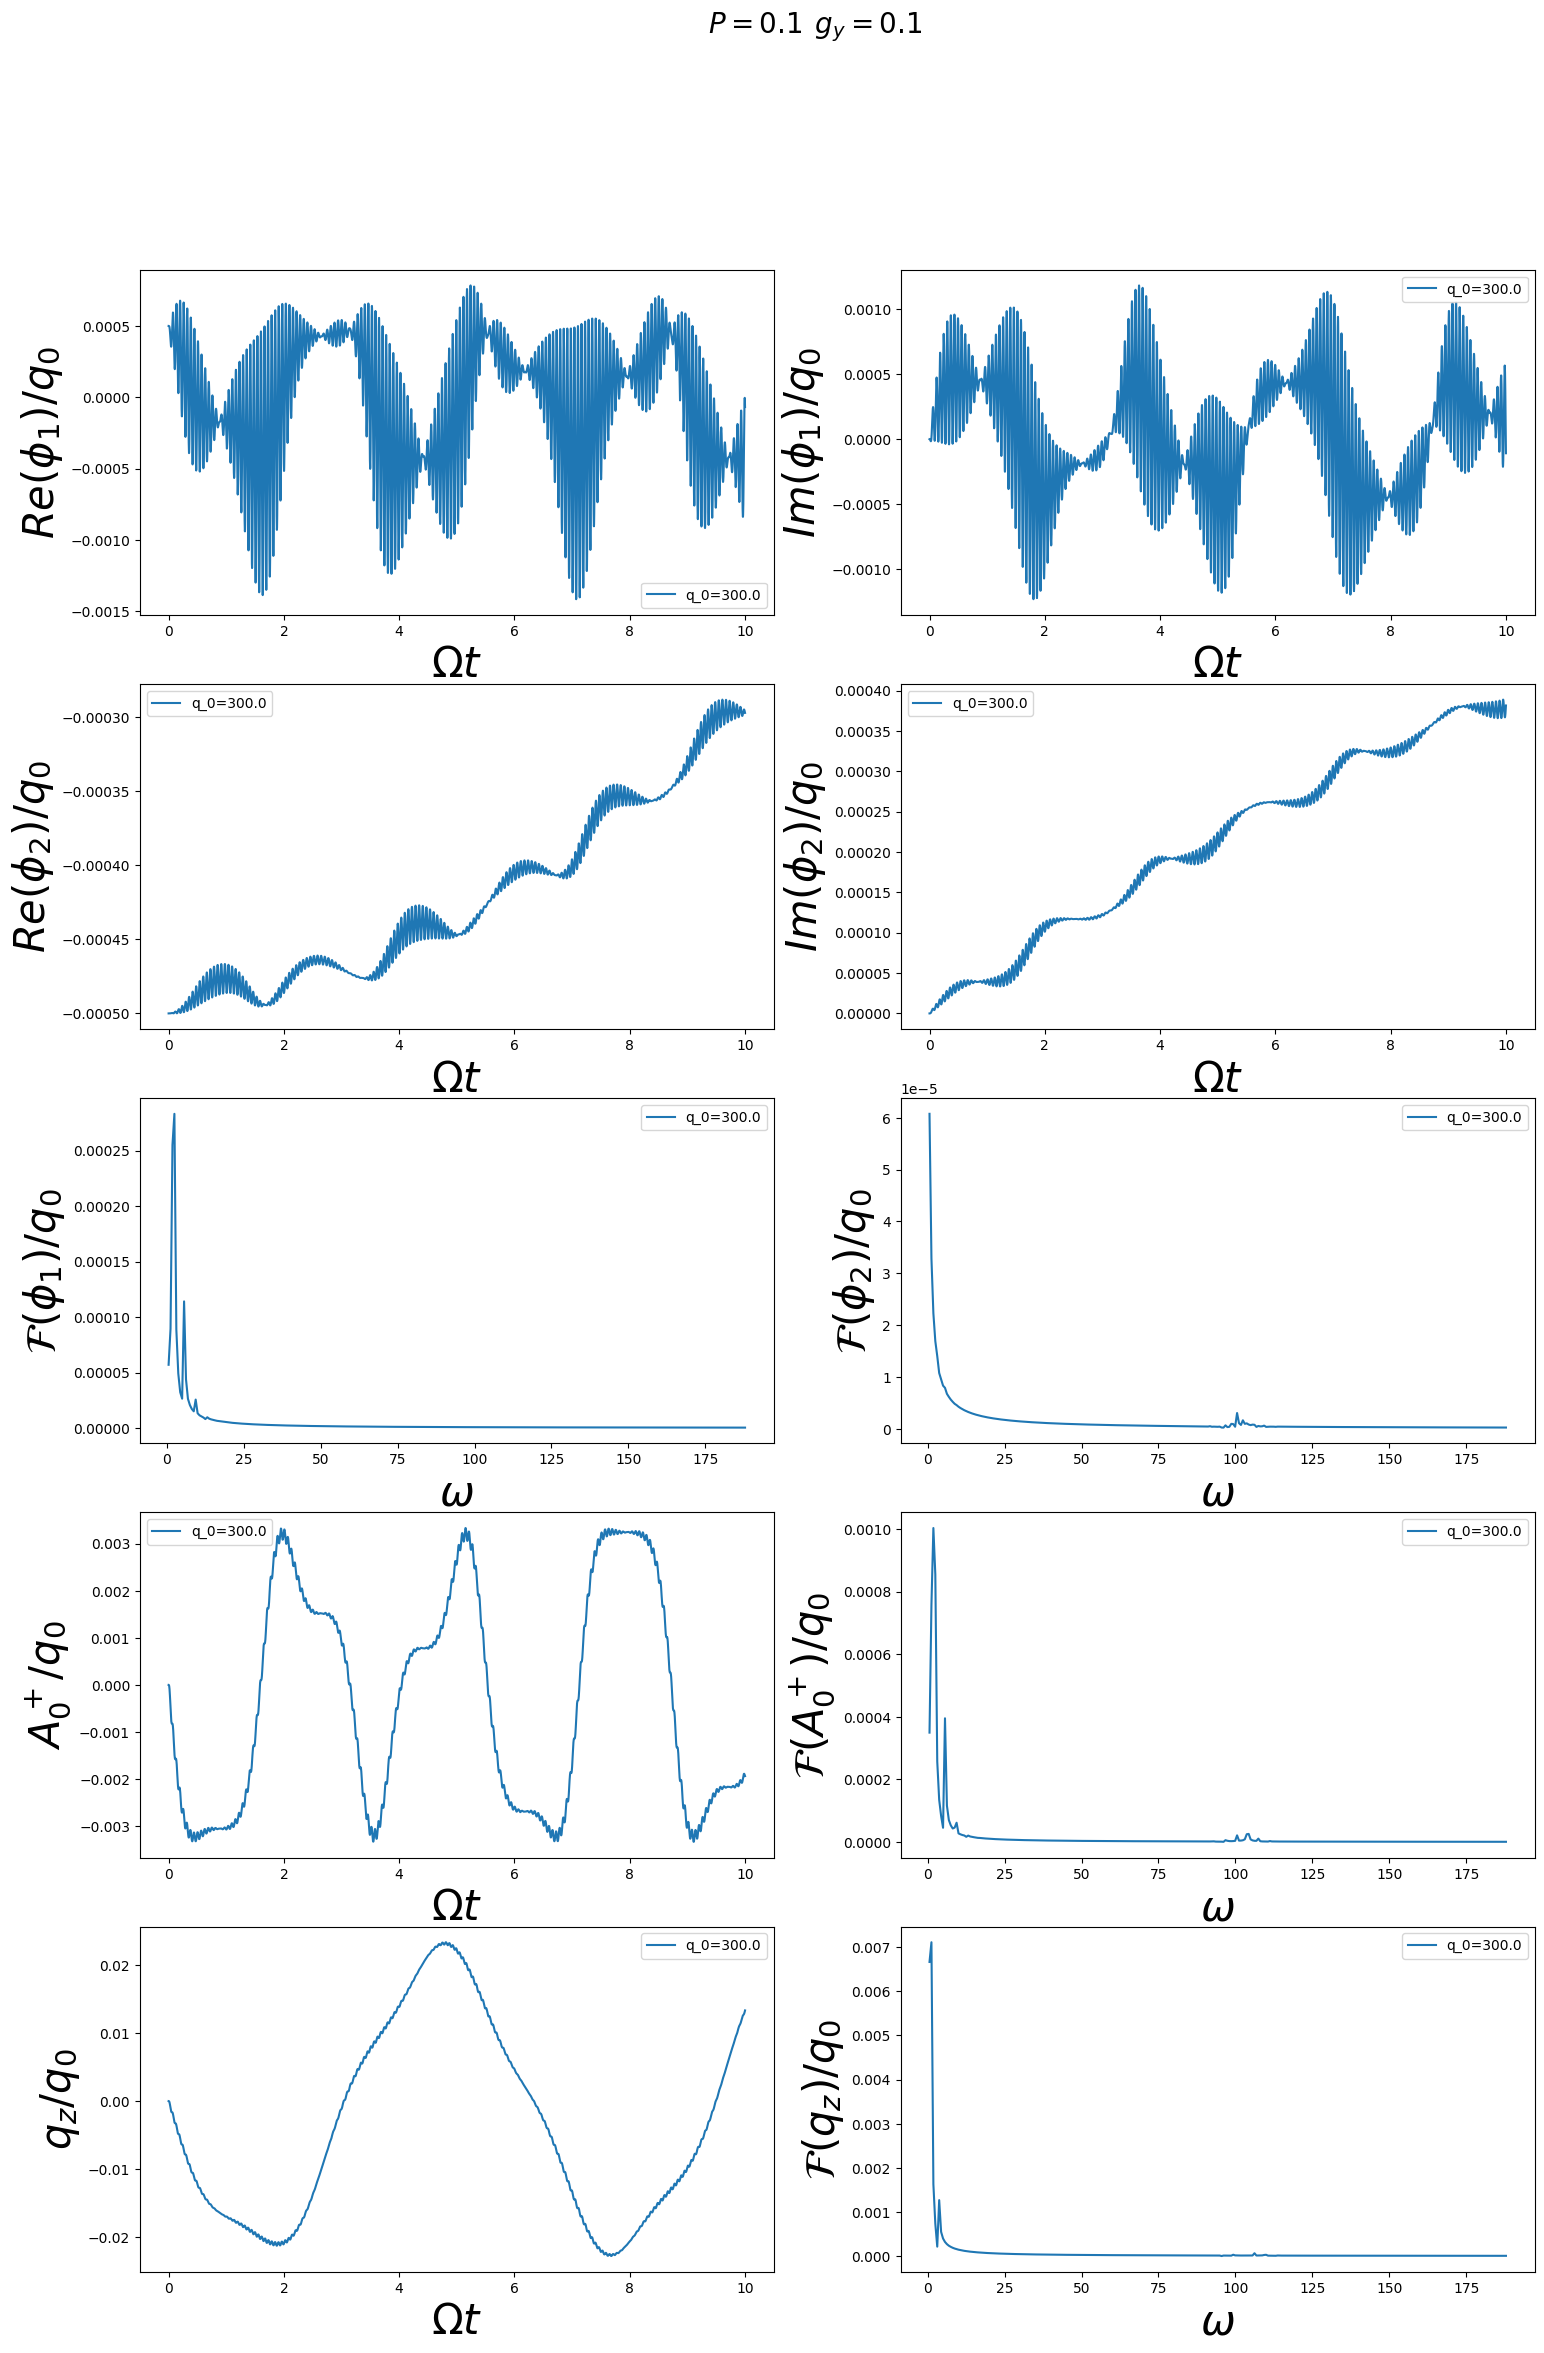

In [73]:

########
P=0.1 ############### TUNING parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)

title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,np.round(N0),P)

label_list=["$\phi_1$","$\phi_3$","$A_0^+$","$q_z$"]
tf=1e1
N_step=10000
# qy_0_list=np.round(np.logspace(-1,1,1),2)
qy_0_list=[3e2]
param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
fig, ax = plt.subplots(5, 2,figsize=(18,26))
fig.suptitle(title, fontsize=20)
om_list=2*np.pi*np.arange(N_step)/tf
sf,ef=1,300
for qy_0 in qy_0_list:
    z0=np.array([1,1,-1,-1,0,0,0,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function
#     z0[8]=1
    _,zz,t=phi_stable_evol(z0,tf,param_list,N_step)
    zz=np.array(zz)/qy_0
    ax[0,0].plot(t,np.real(zz[0]),label="q_0={0}".format(qy_0))
    ax[0,1].plot(t,np.imag(zz[0]),label="q_0={0}".format(qy_0))
    
    ax[1,0].plot(t,np.real(zz[1]),label="q_0={0}".format(qy_0))
    ax[1,1].plot(t,np.imag(zz[1]),label="q_0={0}".format(qy_0))
    
    ax[2,0].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[0]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
    ax[2,1].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[1]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
#     ax[2,0].plot(om_list[sf:ef],np.log(np.abs(np.fft.fft(zz[0])))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
#     ax[2,1].plot(om_list[sf:ef],np.log(np.abs(np.fft.fft(zz[1])))[sf:ef]/N_step,label="q_0={0}".format(qy_0))

    ax[3,0].plot(t,np.real(zz[2]),label="q_0={0}".format(qy_0))
    ax[3,1].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[2]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))

    ax[4,0].plot(t,np.real(zz[3]),label="q_0={0}".format(qy_0))
    ax[4,1].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[3]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
    

ax[0,0].set_ylabel("$Re(\phi_1)/q_0$",fontsize=30)
ax[0,0].set_xlabel('$\Omega  t$',fontsize=30)
ax[0,0].legend(loc="best")

ax[0,1].set_ylabel("$Im(\phi_1)/q_0$",fontsize=30)
ax[0,1].set_xlabel('$\Omega  t$',fontsize=30)
ax[0,1].legend(loc="best")

ax[1,0].set_ylabel("$Re(\phi_2)/q_0$",fontsize=30)
ax[1,0].set_xlabel('$\Omega  t$',fontsize=30)
ax[1,0].legend(loc="best")

ax[1,1].set_ylabel("$Im(\phi_2)/q_0$",fontsize=30)
ax[1,1].set_xlabel('$\Omega  t$',fontsize=30)
ax[1,1].legend(loc="best")

ax[2,0].set_ylabel("$\mathcal{F}(\phi_1)/q_0$",fontsize=30)
ax[2,0].set_xlabel('$\omega$',fontsize=30)
ax[2,0].legend(loc="best")

ax[2,1].set_ylabel("$\mathcal{F}(\phi_2)/q_0$",fontsize=30)
ax[2,1].set_xlabel('$\omega$',fontsize=30)
ax[2,1].legend(loc="best")

ax[3,0].set_ylabel("$A_0^+/q_0$",fontsize=30)
ax[3,0].set_xlabel('$\Omega t$',fontsize=30)
ax[3,0].legend(loc="best")

ax[3,1].set_ylabel("$\mathcal{F}(A_0^+)/q_0$",fontsize=30)
ax[3,1].set_xlabel('$\omega$',fontsize=30)
ax[3,1].legend(loc="best")

ax[4,0].set_ylabel("$q_z/q_0$",fontsize=30)
ax[4,0].set_xlabel('$\Omega t$',fontsize=30)
ax[4,0].legend(loc="best")

ax[4,1].set_ylabel("$\mathcal{F}(q_z)/q_0$",fontsize=30)
ax[4,1].set_xlabel('$\omega$',fontsize=30)
ax[4,1].legend(loc="best") 
plt.suptitle("$P={0} \: \: g_y={1}$".format(P,g_y),fontsize=20)
plt.show()

True


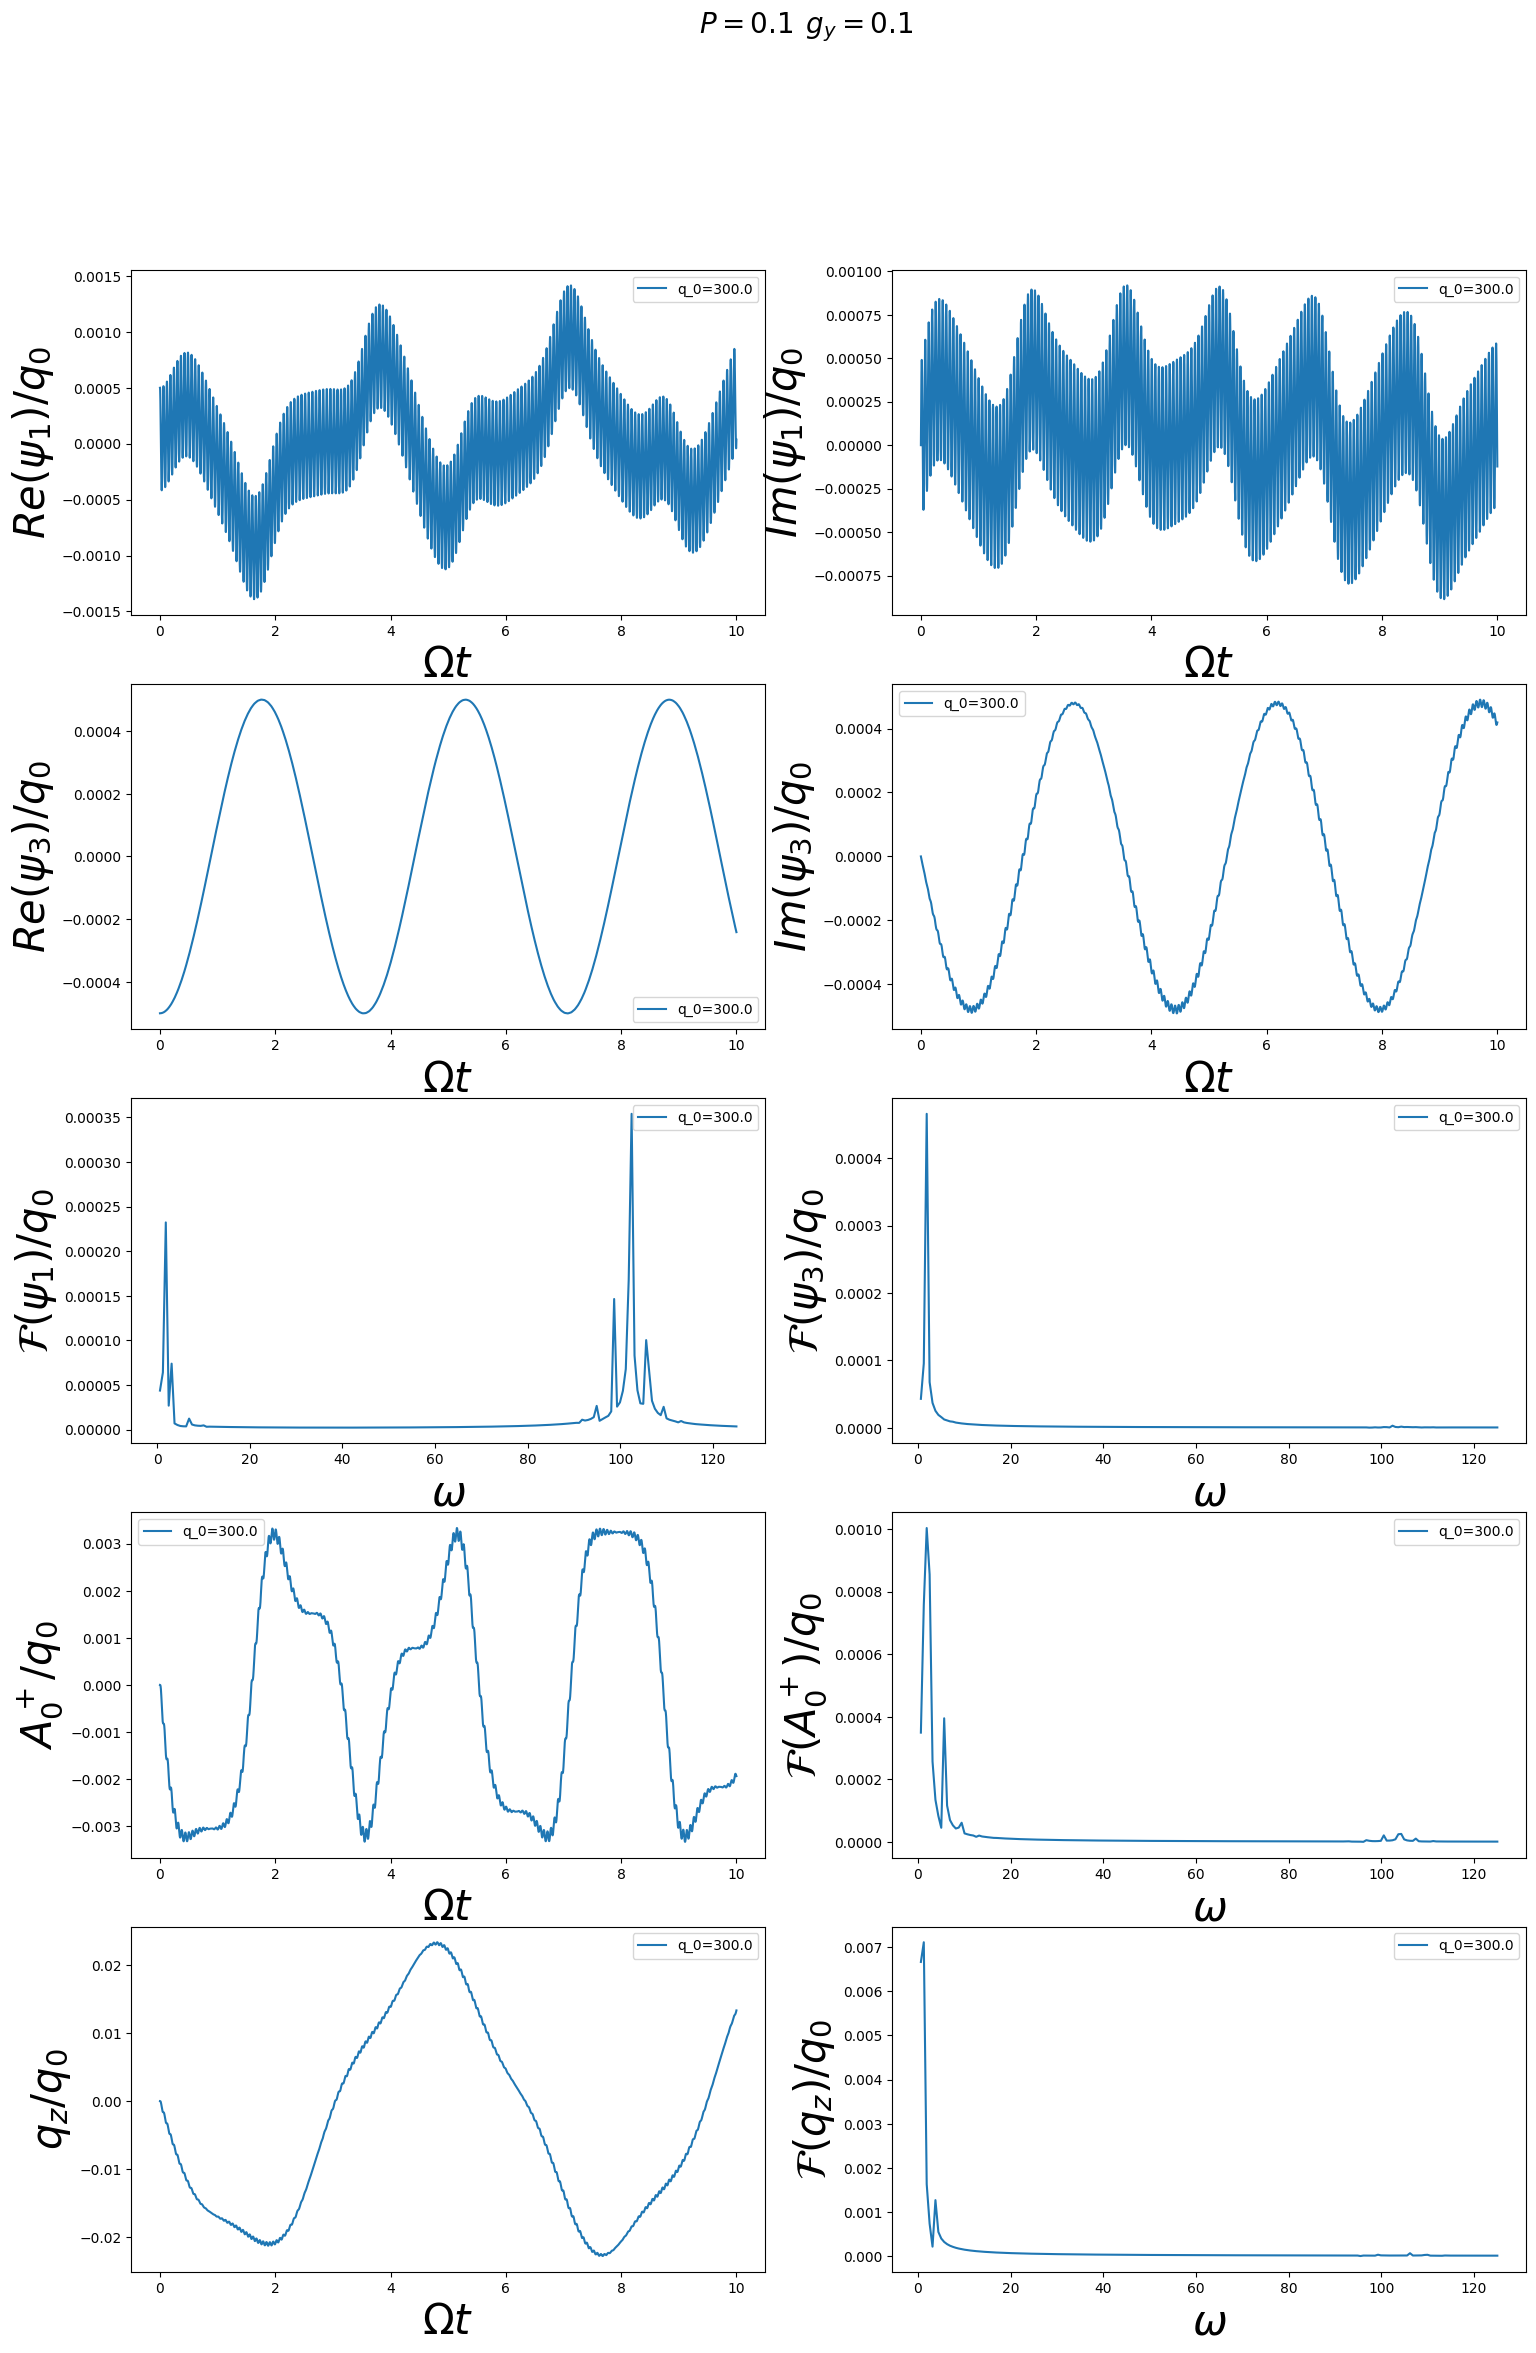

In [69]:
P=0.1 ############### TUNING parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)

title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,np.round(N0),P)

label_list=["$\psi_1$","$\psi_3$","$A_0^+$","$q_z$"]
tf=1e1
N_step=10000
# qy_0_list=np.round(np.logspace(-1,1,1),2)
qy_0_list=[3e2]
param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
fig, ax = plt.subplots(5, 2,figsize=(18,26))
fig.suptitle(title, fontsize=20)
om_list=2*np.pi*np.arange(N_step)/tf
sf,ef=1,200
for qy_0 in qy_0_list:
    z0=np.array([1,1,-1,-1,0,0,0,0,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function
    z0[8]=1
    _,zz,t=psi_evol(z0,tf,param_list,N_step)
    zz=np.array(zz)/qy_0
    ax[0,0].plot(t,np.real(zz[0]),label="q_0={0}".format(qy_0))
    ax[0,1].plot(t,np.imag(zz[0]),label="q_0={0}".format(qy_0))
    
    ax[1,0].plot(t,np.real(zz[1]),label="q_0={0}".format(qy_0))
    ax[1,1].plot(t,np.imag(zz[1]),label="q_0={0}".format(qy_0))
    
    ax[2,0].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[0]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
    ax[2,1].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[1]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
    
    ax[3,0].plot(t,np.real(zz[2]),label="q_0={0}".format(qy_0))
    ax[3,1].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[2]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))

    ax[4,0].plot(t,np.real(zz[3]),label="q_0={0}".format(qy_0))
    ax[4,1].plot(om_list[sf:ef],np.abs(np.fft.fft(zz[3]))[sf:ef]/N_step,label="q_0={0}".format(qy_0))
    

ax[0,0].set_ylabel("$Re(\psi_1)/q_0$",fontsize=30)
ax[0,0].set_xlabel('$\Omega  t$',fontsize=30)
ax[0,0].legend(loc="best")

ax[0,1].set_ylabel("$Im(\psi_1)/q_0$",fontsize=30)
ax[0,1].set_xlabel('$\Omega  t$',fontsize=30)
ax[0,1].legend(loc="best")

ax[1,0].set_ylabel("$Re(\psi_3)/q_0$",fontsize=30)
ax[1,0].set_xlabel('$\Omega  t$',fontsize=30)
ax[1,0].legend(loc="best")

ax[1,1].set_ylabel("$Im(\psi_3)/q_0$",fontsize=30)
ax[1,1].set_xlabel('$\Omega  t$',fontsize=30)
ax[1,1].legend(loc="best")

ax[2,0].set_ylabel("$\mathcal{F}(\psi_1)/q_0$",fontsize=30)
ax[2,0].set_xlabel('$\omega$',fontsize=30)
ax[2,0].legend(loc="best")

ax[2,1].set_ylabel("$\mathcal{F}(\psi_3)/q_0$",fontsize=30)
ax[2,1].set_xlabel('$\omega$',fontsize=30)
ax[2,1].legend(loc="best")

ax[3,0].set_ylabel("$A_0^+/q_0$",fontsize=30)
ax[3,0].set_xlabel('$\Omega t$',fontsize=30)
ax[3,0].legend(loc="best")

ax[3,1].set_ylabel("$\mathcal{F}(A_0^+)/q_0$",fontsize=30)
ax[3,1].set_xlabel('$\omega$',fontsize=30)
ax[3,1].legend(loc="best")

ax[4,0].set_ylabel("$q_z/q_0$",fontsize=30)
ax[4,0].set_xlabel('$\Omega t$',fontsize=30)
ax[4,0].legend(loc="best")

ax[4,1].set_ylabel("$\mathcal{F}(q_z)/q_0$",fontsize=30)
ax[4,1].set_xlabel('$\omega$',fontsize=30)
ax[4,1].legend(loc="best") 
plt.suptitle("$P={0} \: \: g_y={1}$".format(P,g_y),fontsize=20)
plt.show()

True
[[ 0.00000000e+00+0.j -2.22044605e-16+0.j  3.55271368e-15+0.j
   0.00000000e+00+0.j]
 [ 4.44089210e-16+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -1.85991667e-10+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  2.16840434e-19+0.j -2.84217094e-14+0.j
   0.00000000e+00+0.j]]
(1.0000000000000004+0j)


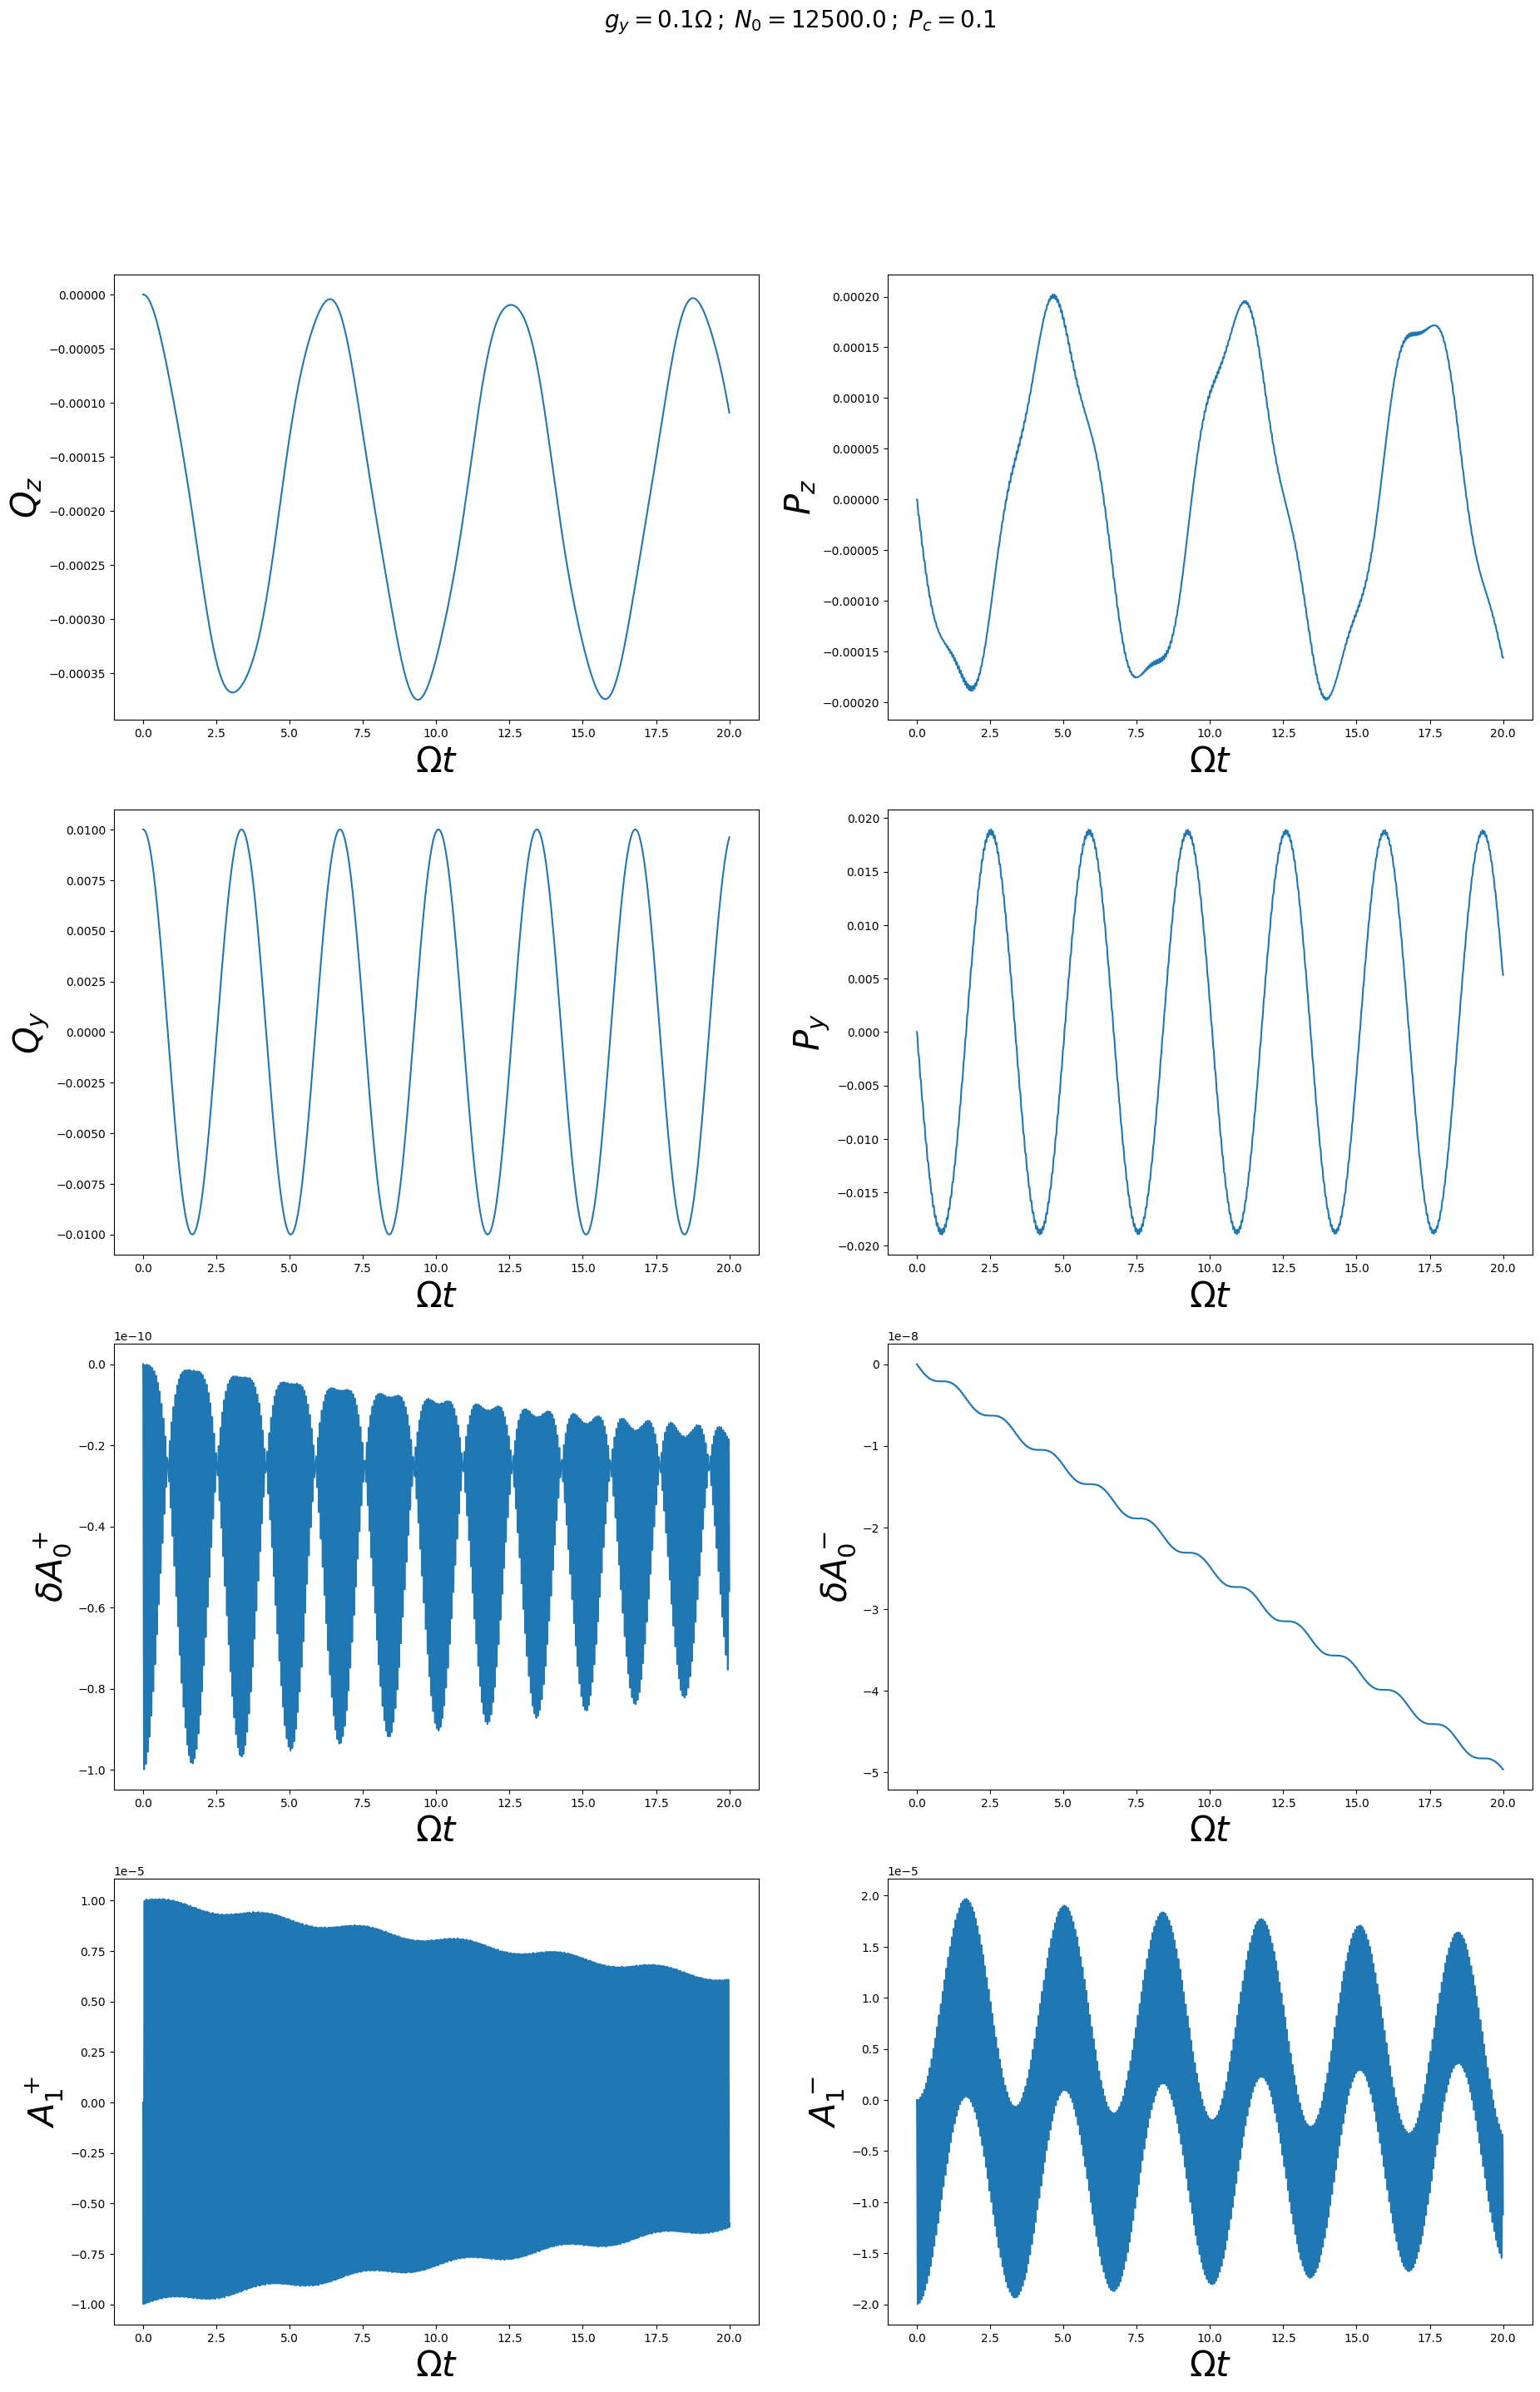

In [35]:
P_c=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P_c*del_omega)**3/(8*g_y**2)

title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,np.round(N0),P_c)

# label_list=["$q_y$","$p_y$","$A_1^+$","$A_1^-$","$\delta A_0^+$","$\delta A_0^-$","$q_z$","$p_z$"]
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]
tf=2e1
N_step=10000
# N0=1
qy_0=1e-2
z0=np.array([1,1,-1,-1,0,0,0,0,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function
z0[8]=1


# param_list=[del_omega,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq

zz,t=psi_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle(title, fontsize=20)
for i in range(8):
#     axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

N0= 12499.999999999998
lam= 99.98749484047796 nu= 1.871062672759006
[[ 0.0e+00+0.j  1.0e+00+0.j -0.0e+00+0.j  0.0e+00+0.j]
 [-1.0e+00+0.j  0.0e+00+0.j  0.0e+00+0.j  2.5e+03+0.j]
 [-1.0e-01+0.j  0.0e+00+0.j  0.0e+00+0.j -1.0e+02+0.j]
 [ 0.0e+00+0.j -0.0e+00+0.j  1.0e+02+0.j  0.0e+00+0.j]]
initial condition [-1.00050047e+00-1.11279539e-08j  1.10824754e-08+3.94510247e-09j
 -4.41639300e-13-7.23774271e-14j  2.00120107e-03+1.14626681e-11j]


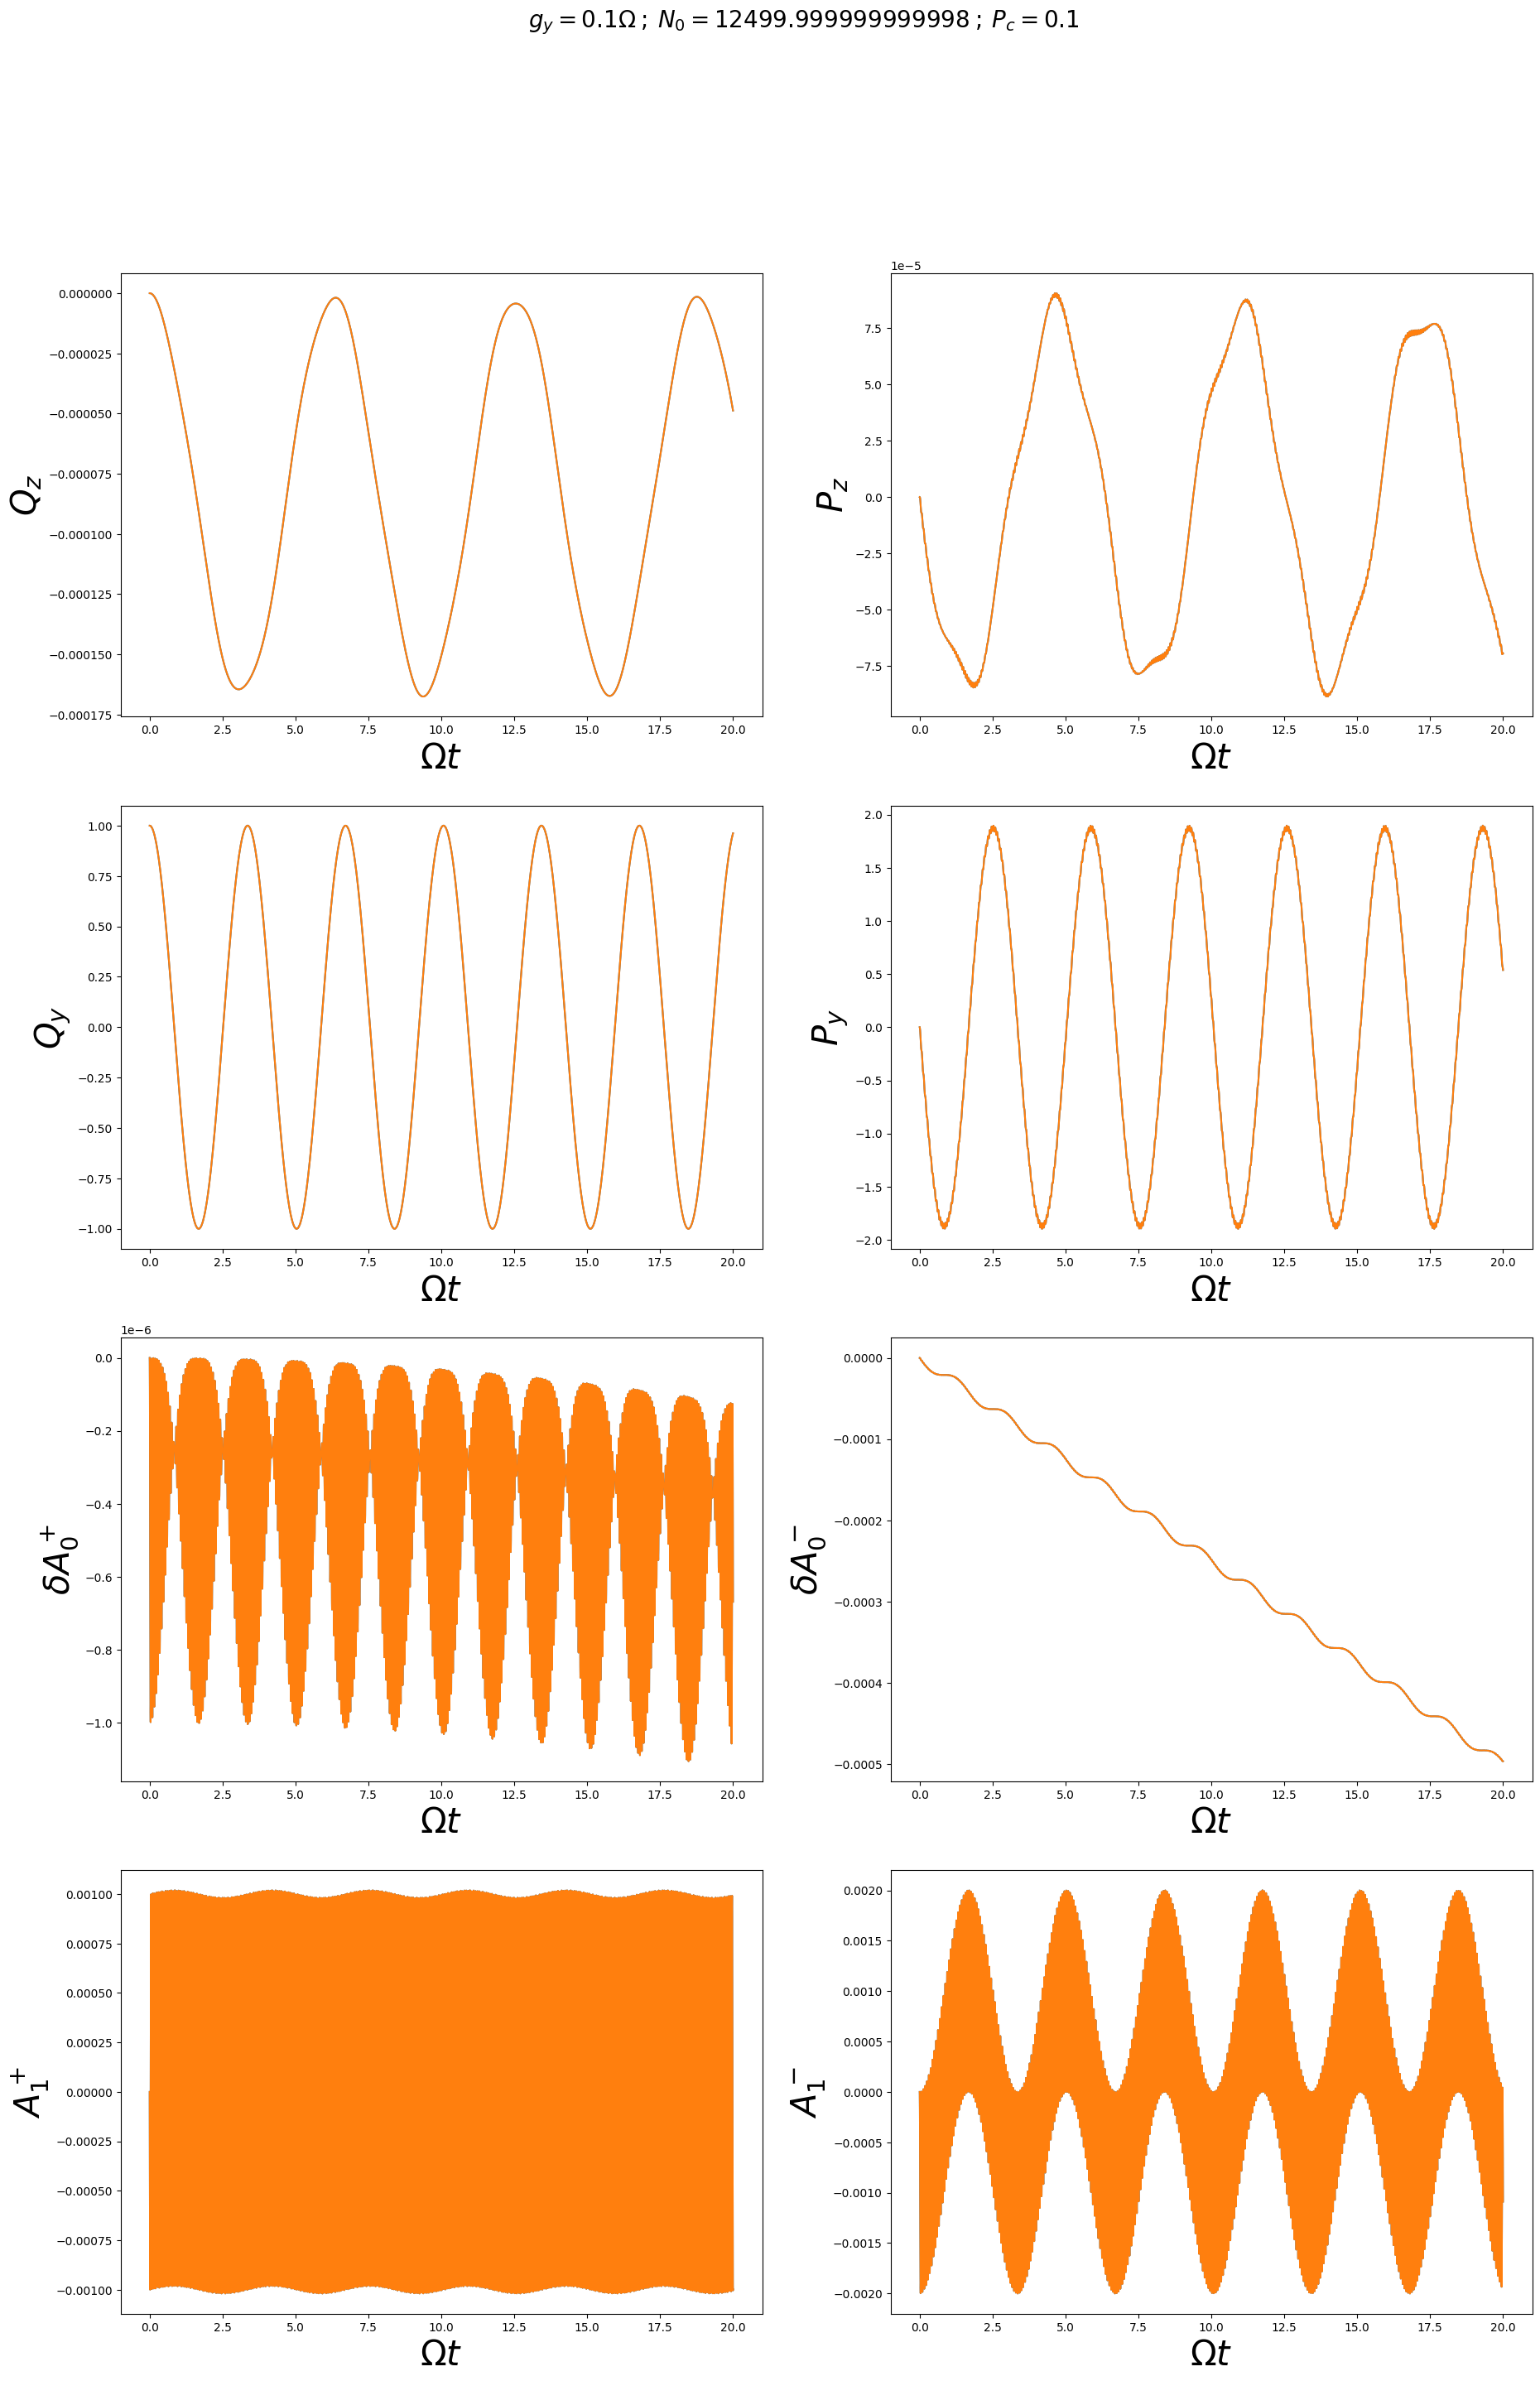

In [22]:
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

tf=2e1
N_step=10000
N0_list=[N0]
qy_0=1
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])  ### 0 mode excitation

param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz1,t1=real_evolve(z_0,tf,param_list,N_step)
###########

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]
z0=np.array([1,1,-1,-1,0,0,0,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function


# param_list=[del_omega,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz2,t2=phi_stable_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
fig.suptitle(title, fontsize=20)
for i in range(8):
#     axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].plot(t1,zz1[i],t2,zz2[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

In [23]:

    
def phi_avg_evol(z0,tf,param_list,N_step=300):
    
    g_z1,g_y,delta,N0=param_list
    D=((1-delta**2)**2-8*g_y**2*N0*delta)**0.5
    lam=((1+delta**2+D)/2)**0.5
    nu=((1+delta**2-D)/2)**0.5
    print("lam=",lam,"nu=",nu)
    lp=(1-delta**2+D)/(2*delta*g_y)
    lm=(1-delta**2-D)/(2*delta*g_y)
    param_list=[lam,nu,D,delta,g_y,N0]
    U=np.array([
                [lp,lp,lm,lm],
                [-1j*lp*lam,1j*lp*lam,-1j*lm*nu,1j*lm*nu],
                [-1j*lam/delta,1j*lam/delta,-1j*nu/delta,1j*nu/delta],
                [1,1,1,1]
    ])

    def phi_avg_ODE(t,z,lam,nu,D,delta,g,N0):
        phi_1,p_1,phi_2,p_2=z
        a11=2*g**2*N0*lam*nu**2+3*lam**3*nu**4/delta
        a12=2*g**2*N0*(lam**3+2*nu**3)+lam**4*nu**2*(lam+2*nu)/delta+lam**5*delta
        a21=2*g**2*N0*lam**2*nu+3*lam**4*nu**3/delta
        a22=2*g**2*N0*(2*lam**3+nu**3)+lam**2*nu**4*(2*lam+nu)/delta+nu**5*delta

        phi_1_dot=p_1
        phi_2_dot=p_2
        p_1_dot=-phi_1*(a11*np.abs(phi_1)**2+a12*np.abs(phi_2)**2)/(2*delta*D*lam)
        p_2_dot=phi_2*(a21*np.abs(phi_2)**2+a22*np.abs(phi_1)**2)/(2*delta*D*nu)

        x_list=[phi_1_dot,p_1_dot,phi_2_dot,p_2_dot]
        return x_list

    
    def phi_to_real(zz):
        temp=np.array(zz,dtype=complex)
        N_step=len(zz[0])
        yy=[]
        for i in range(N_step):
            E=np.diag(np.exp( 1j*t_list[i]*np.array([-lam,lam,-nu,nu])))
            P=np.array([zz[0,i],zz[0,i].conj(),zz[1,i],zz[1,i].conj()])
            yy.append(np.einsum("ij,j",U@E,P))
        temp[:4]=np.array(yy).T
        return temp 

    
    t_list = np.linspace(0,tf,N_step)
    z0[:4]*=delta*g_y/(2*D)
    xx=solve_ivp(phi_avg_ODE, [0,tf],z0,args=param_list,dense_output=False,rtol = 1e-8, atol = 1e-12, t_eval=t_list)
    zz=xx.y
    yy=np.real(phi_to_real(zz))

    sol=[]
    sol.extend( (yy[0],yy[1],yy[2],yy[3]) )
    return sol,t_list

N0= 12499.999999999998
lam= 99.98749484047796 nu= 1.871062672759006


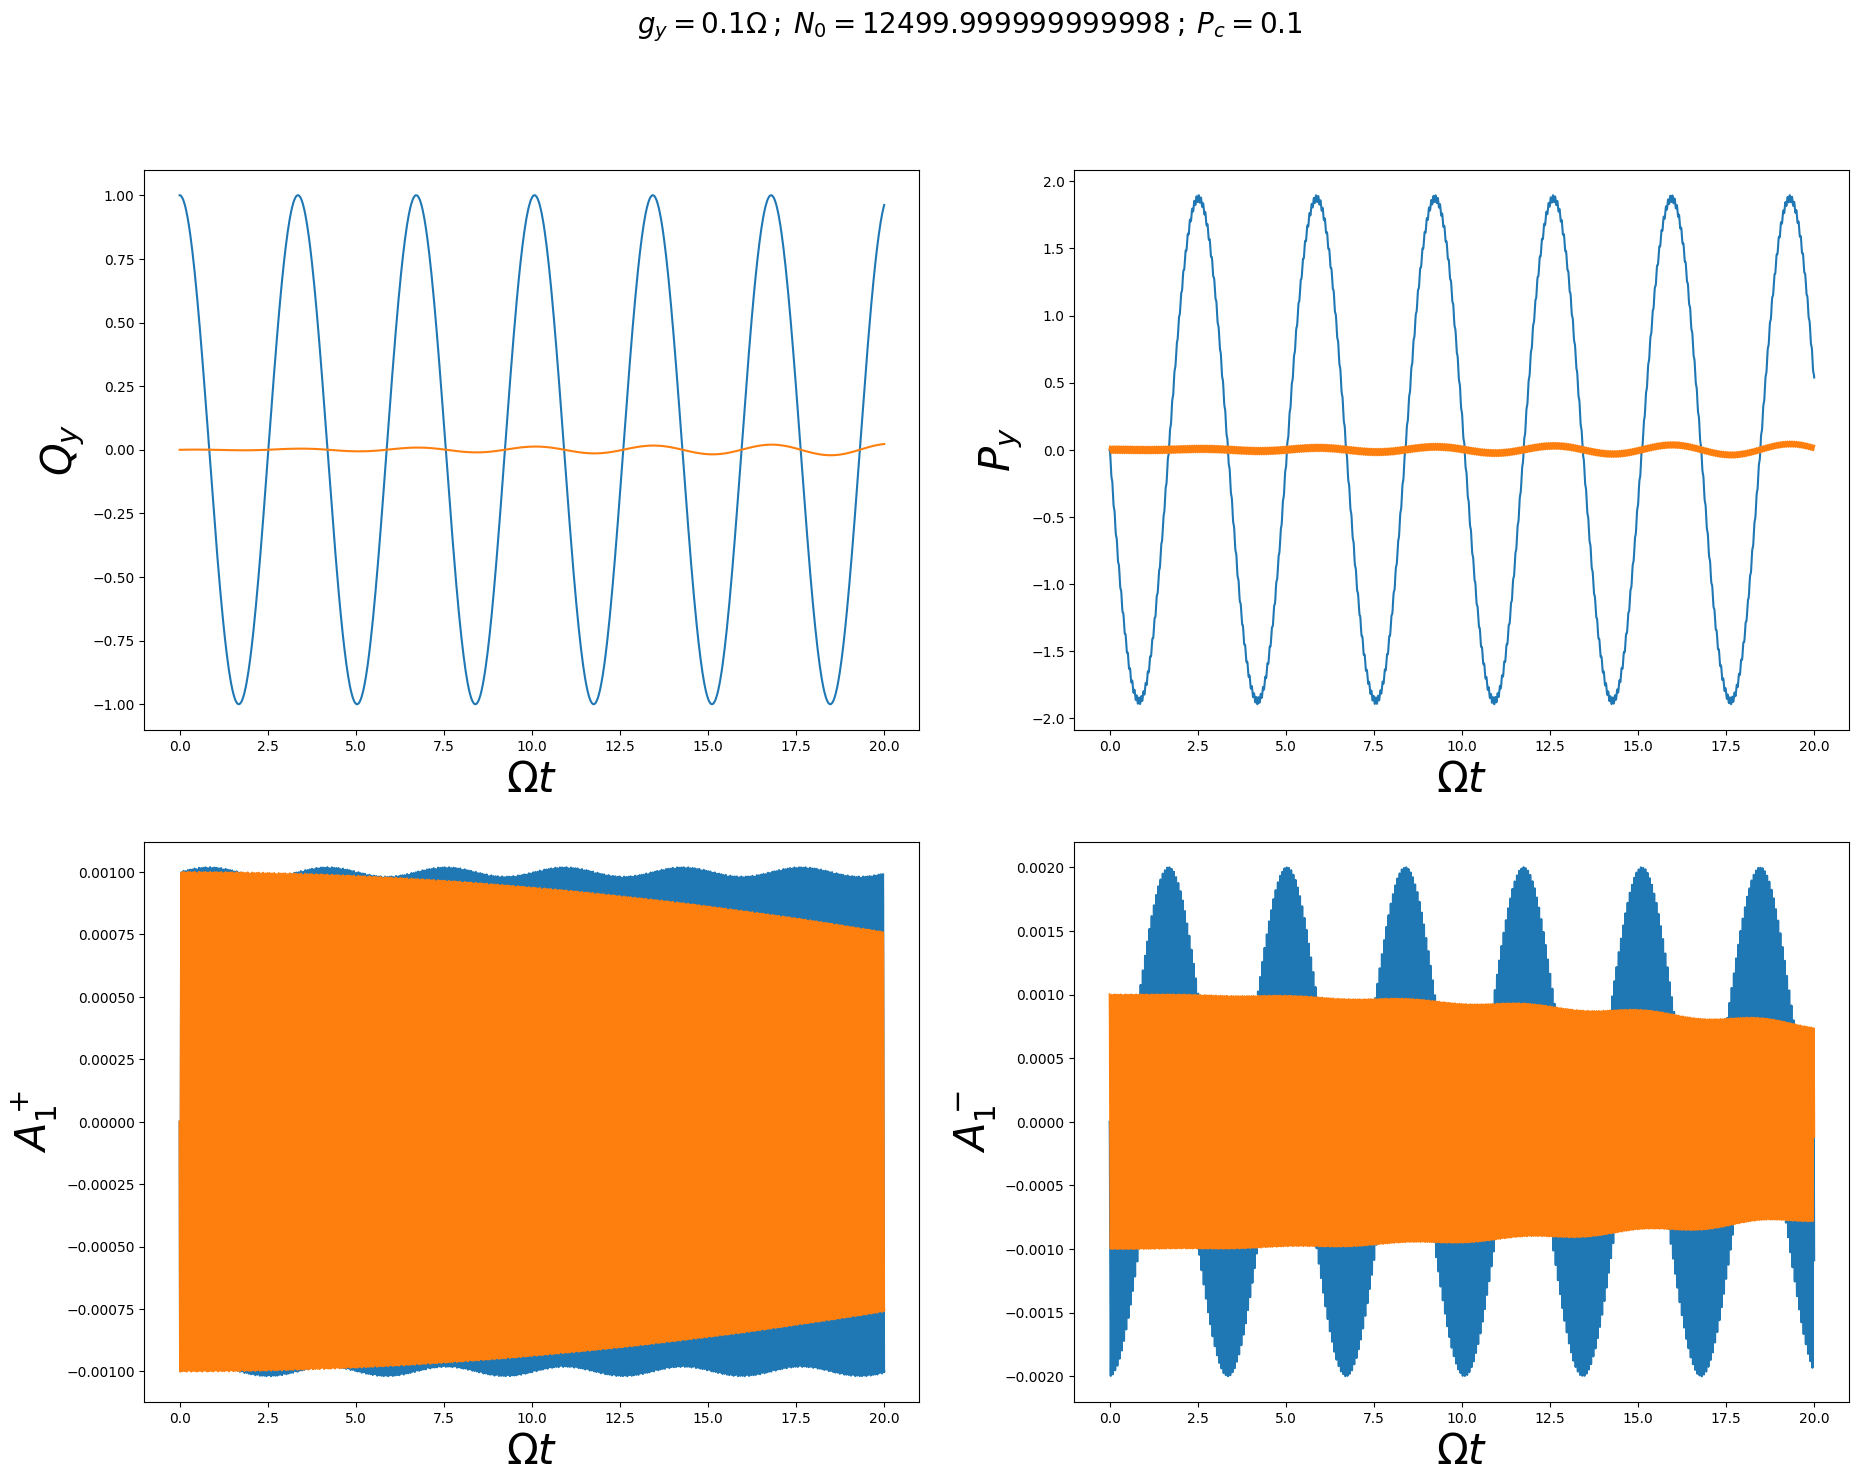

In [24]:
P=0.1 ############### CRITICAL parameter
g_y=1e-1
N0=(P*del_omega)**3/(8*g_y**2)
print("N0=",N0)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P)

tf=2e1
N_step=10000
N0_list=[N0]
qy_0=1
z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])  ### 0 mode excitation

param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz1,t1=real_evolve(z_0,tf,param_list,N_step)
###########
# label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]
label_list=["$Q_y$","$P_y$","$A_1^+$","$A_1^-$"]
z0=np.array([1,0,-1,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function


# param_list=[del_omega,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz2,t2=phi_avg_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(22,16))
fig.suptitle(title, fontsize=20)
kl=[2,3,6,7]
for i in range(4):
#     axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].plot(t1,zz1[kl[i]],t2,zz2[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

In [42]:
g_y=1e-1
tf=2e1
N_step=10000
N_grid=101
P_c=0.9
if P_c<=1:
    tt="stable"
else:
    tt="chaotic"
N0=(P_c*del_omega)**3/(8*g_y**2)
param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
qy_0_list=np.linspace(0,1,N_grid)*10**2

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$E_{opt}^{(0)}$","$E_{opt}^{(1)}$","$E_{mech}_z$","$E_{mech}_y$","$E_{c}$"]
t_start=datetime.datetime.now()

for i,qy_0 in enumerate(qy_0_list):
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])
    start=datetime.datetime.now()
    zz,t=real_evolve(z_0,tf,param_list,N_step)
    time_taken=(datetime.datetime.now()-start).total_seconds()
    print("time taken for qy_0={0} is {1}".format(np.round(qy_0,4),time_taken))
    file="real_"+tt+"_P_c={0}_g_y={1}_tf={2}_qy_0={3}".format(np.round(P_c,4),g_y,tf,np.round(qy_0,4))
    np.savez_compressed(folder+file, sol=zz, t=t,label=label_list,param=param_list,time_taken=time_taken)
    
total_t=t_start-datetime.datetime.now()
print("total time taken = ",total_t.total_seconds())

time taken for qy_0=0.0 is 0.004047
time taken for qy_0=1.0 is 2.150716
time taken for qy_0=2.0 is 2.108471
time taken for qy_0=3.0 is 2.276717
time taken for qy_0=4.0 is 1.959918
time taken for qy_0=5.0 is 1.981984
time taken for qy_0=6.0 is 1.975303
time taken for qy_0=7.0 is 2.18455
time taken for qy_0=8.0 is 2.356235
time taken for qy_0=9.0 is 2.256498
time taken for qy_0=10.0 is 2.147363
time taken for qy_0=11.0 is 2.114052
time taken for qy_0=12.0 is 2.162245
time taken for qy_0=13.0 is 2.345552
time taken for qy_0=14.0 is 2.100621
time taken for qy_0=15.0 is 2.074408
time taken for qy_0=16.0 is 2.19015
time taken for qy_0=17.0 is 1.9867
time taken for qy_0=18.0 is 1.993827
time taken for qy_0=19.0 is 1.958602
time taken for qy_0=20.0 is 1.969664
time taken for qy_0=21.0 is 2.001918
time taken for qy_0=22.0 is 1.980965
time taken for qy_0=23.0 is 1.971377
time taken for qy_0=24.0 is 1.969476
time taken for qy_0=25.0 is 1.984596
time taken for qy_0=26.0 is 2.000871
time taken for 

In [51]:
g_y=1e-1
tf=2e1
N_step=10000
qy_0=6
N_grid=100

# P_c_list=np.linspace(0.01,1,N_grid)
P_c_list=np.array([0.01])

N0_list=(P_c_list*del_omega)**3/(8*g_y**2)
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$E_{opt}^{(0)}$","$E_{opt}^{(1)}$","$E_{mech}_z$","$E_{mech}_y$","$E_{c}$"]
t_start=datetime.datetime.now()

for i,P_c in enumerate(P_c_list):
#     tt="stable" if P_c<=1 else "chaotic" 
    if P_c<=1:
        tt="stable"
    else:
        tt="chaotic"
#         method="BDF"
#     if (100*(i/(N_grid-1)))%10==0:print((100*(i/(N_grid-1))),"% progressed")
    N0=(P_c*del_omega)**3/(8*g_y**2)
    z_0=np.array([0,0,qy_0,0,0,0,0,0, N0*del_omega,0,0, qy_0**2/4,0])
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    start=datetime.datetime.now()
    zz,t=real_evolve(z_0,tf,param_list,N_step)
    time_taken=(datetime.datetime.now()-start).total_seconds()
    print("time taken for P_c={0} is {1}".format(np.round(P_c,4),time_taken))
    file="real_"+tt+"_P_c={0}_g_y={1}_tf={2}_qy_0={3}".format(np.round(P_c,4),g_y,tf,np.round(qy_0,4))
    np.savez_compressed(folder+file, sol=zz, t=t,label=label_list,param=param_list,time_taken=time_taken)
    
total_t=t_start-datetime.datetime.now()
print("total time taken = ",total_t.total_seconds())

time taken for P_c=0.01 is 4.211337
total time taken =  -4.398838


time_taken= 4.211337 seconds


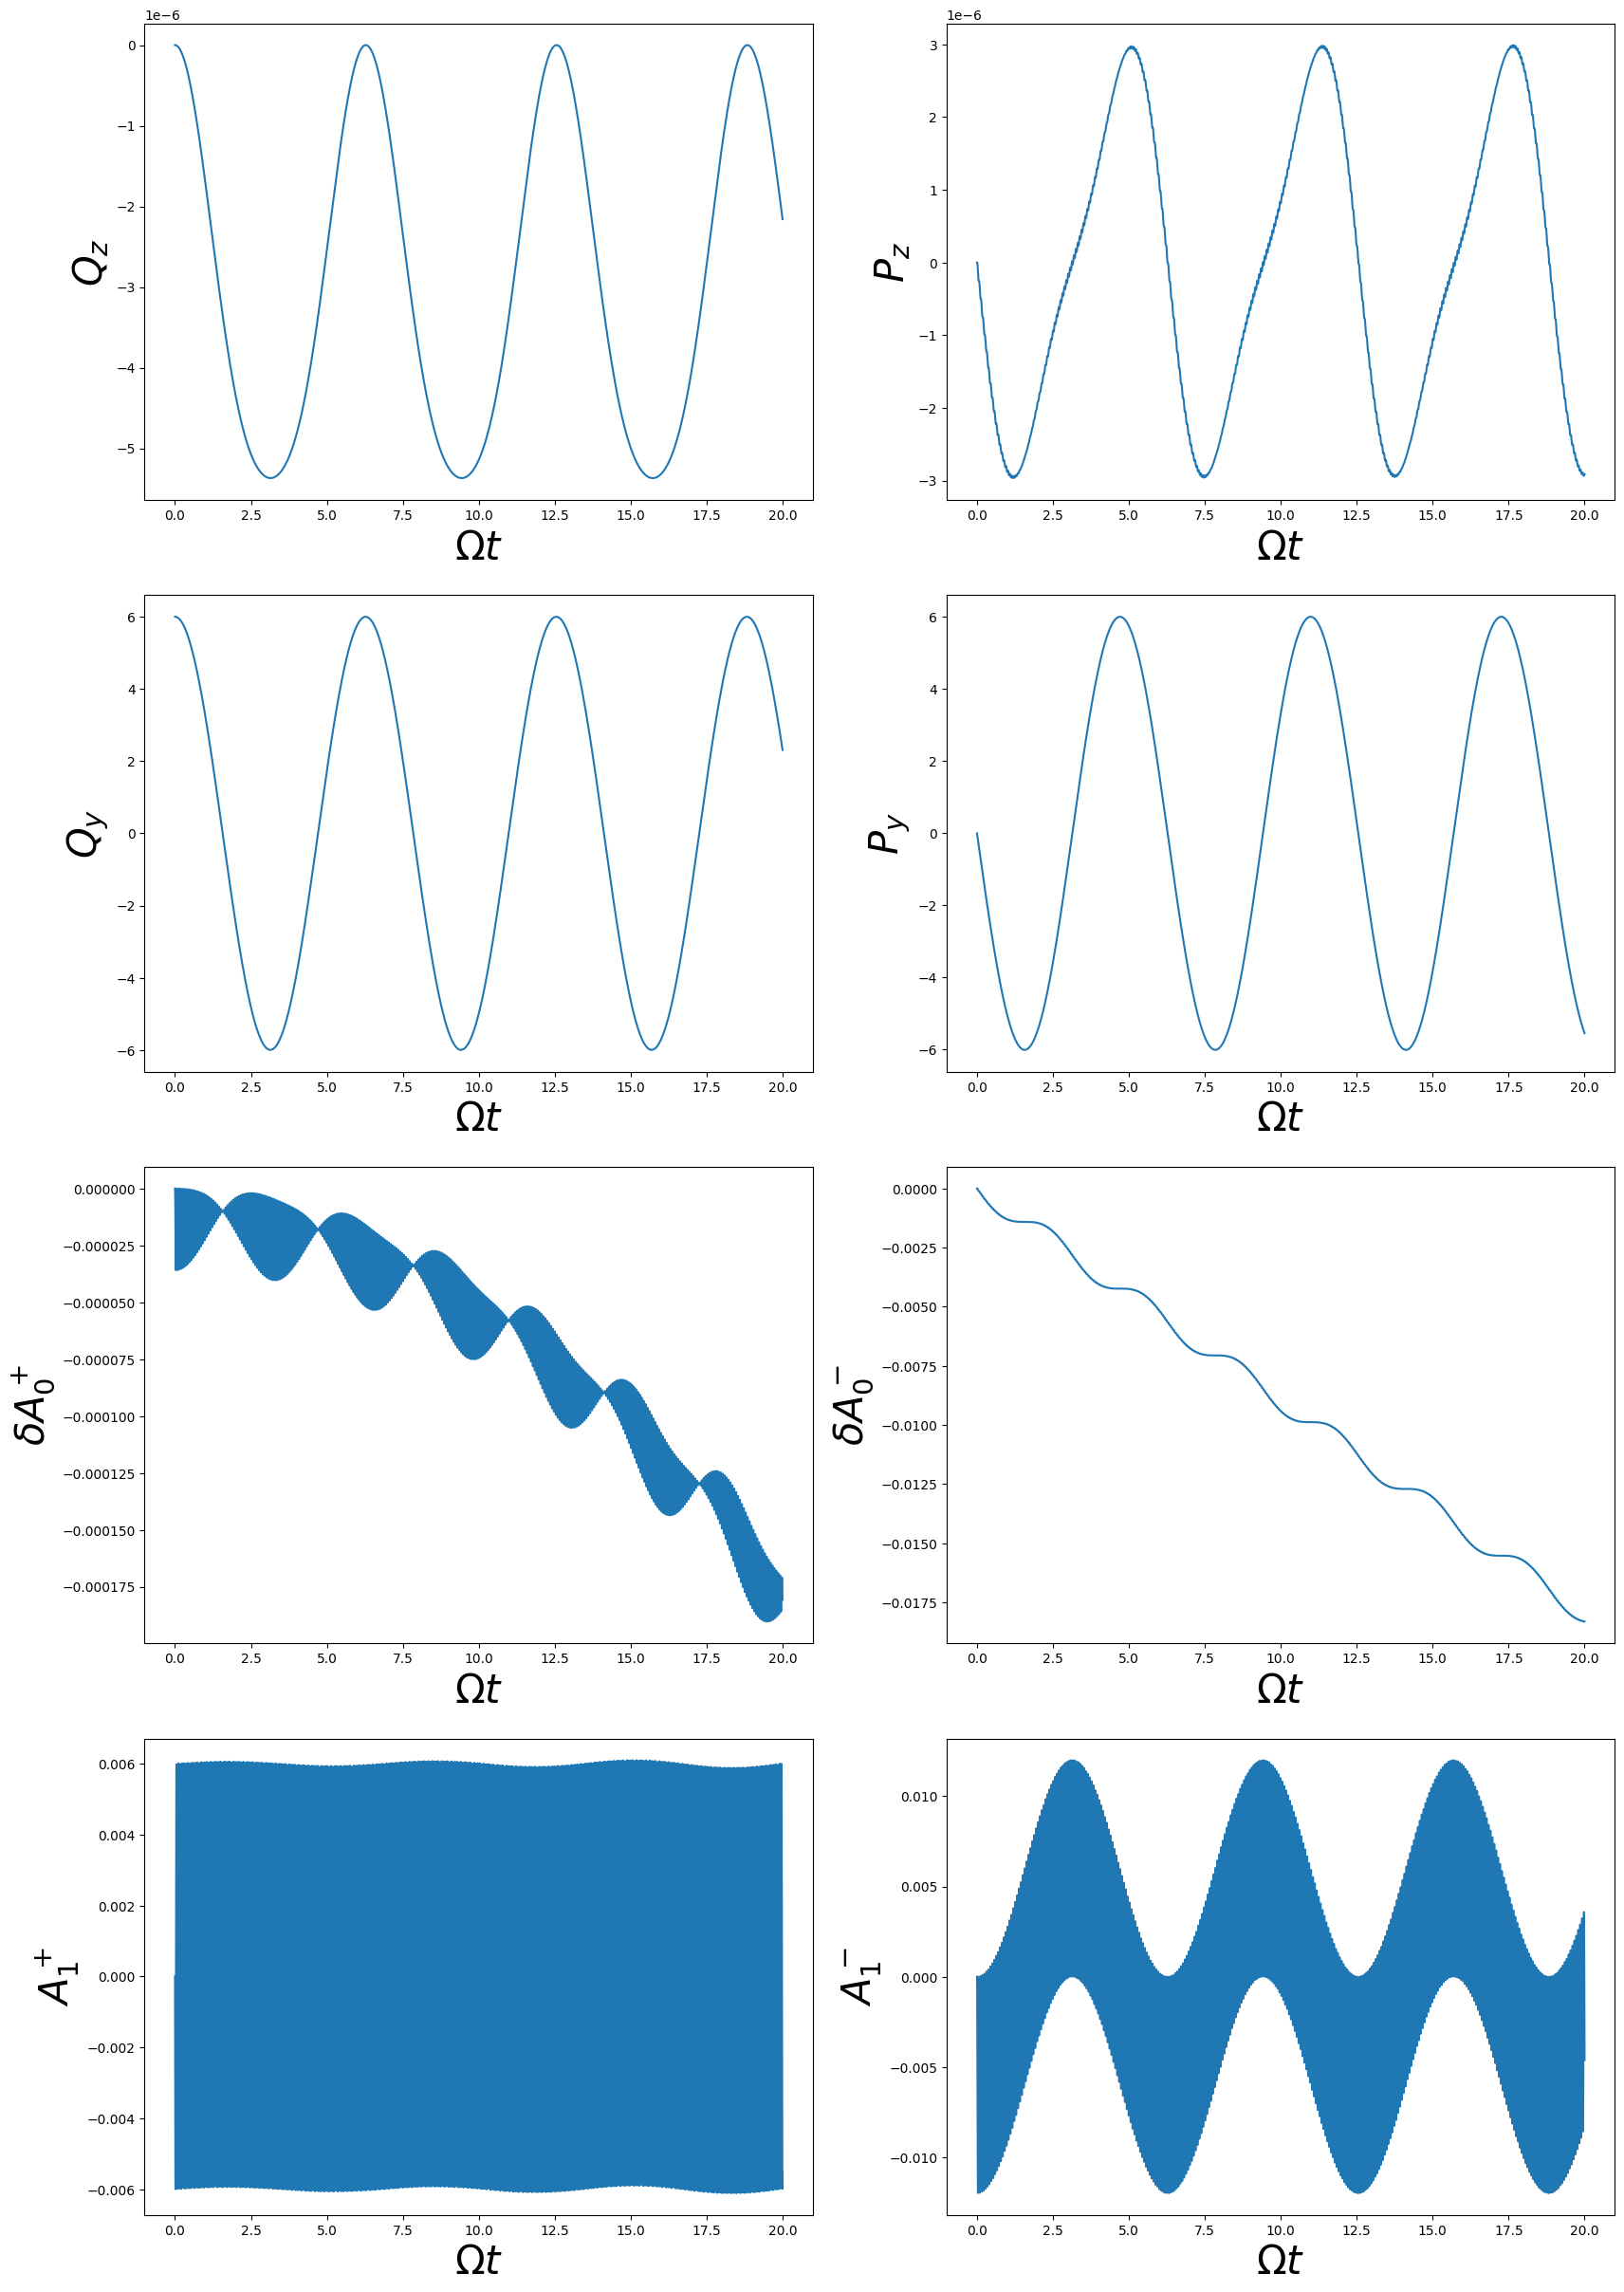

In [52]:
P_c=0.01 ############### CRITICAL parameter
g_y=1e-1
tf=2e1
qy_0=6
D=((1-del_omega**2)**2-P**3*del_omega**4)**0.5
lp=(1-del_omega**2+D)/(2*del_omega*g_y)
lm=(1-del_omega**2-D)/(2*del_omega*g_y)

if P_c<=1:
    tt="stable"
else:
    tt="chaotic"

file="real_"+tt+"_P_c={0}_g_y={1}_tf={2}_qy_0={3}".format(np.round(P_c,4),g_y,tf,np.round(qy_0,4))

data = np.load(folder+file+".npz")
sol_s=data['sol']
t=data['t']
label_list=data['label']
print("time_taken=",data['time_taken'],"seconds")
fig, axs = plt.subplots(4, 2,figsize=(20,30))

for i in range(8):
    axs[i//2,i%2].plot(t[::1],sol_s[i][::1])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

time_taken= 23.422171 seconds


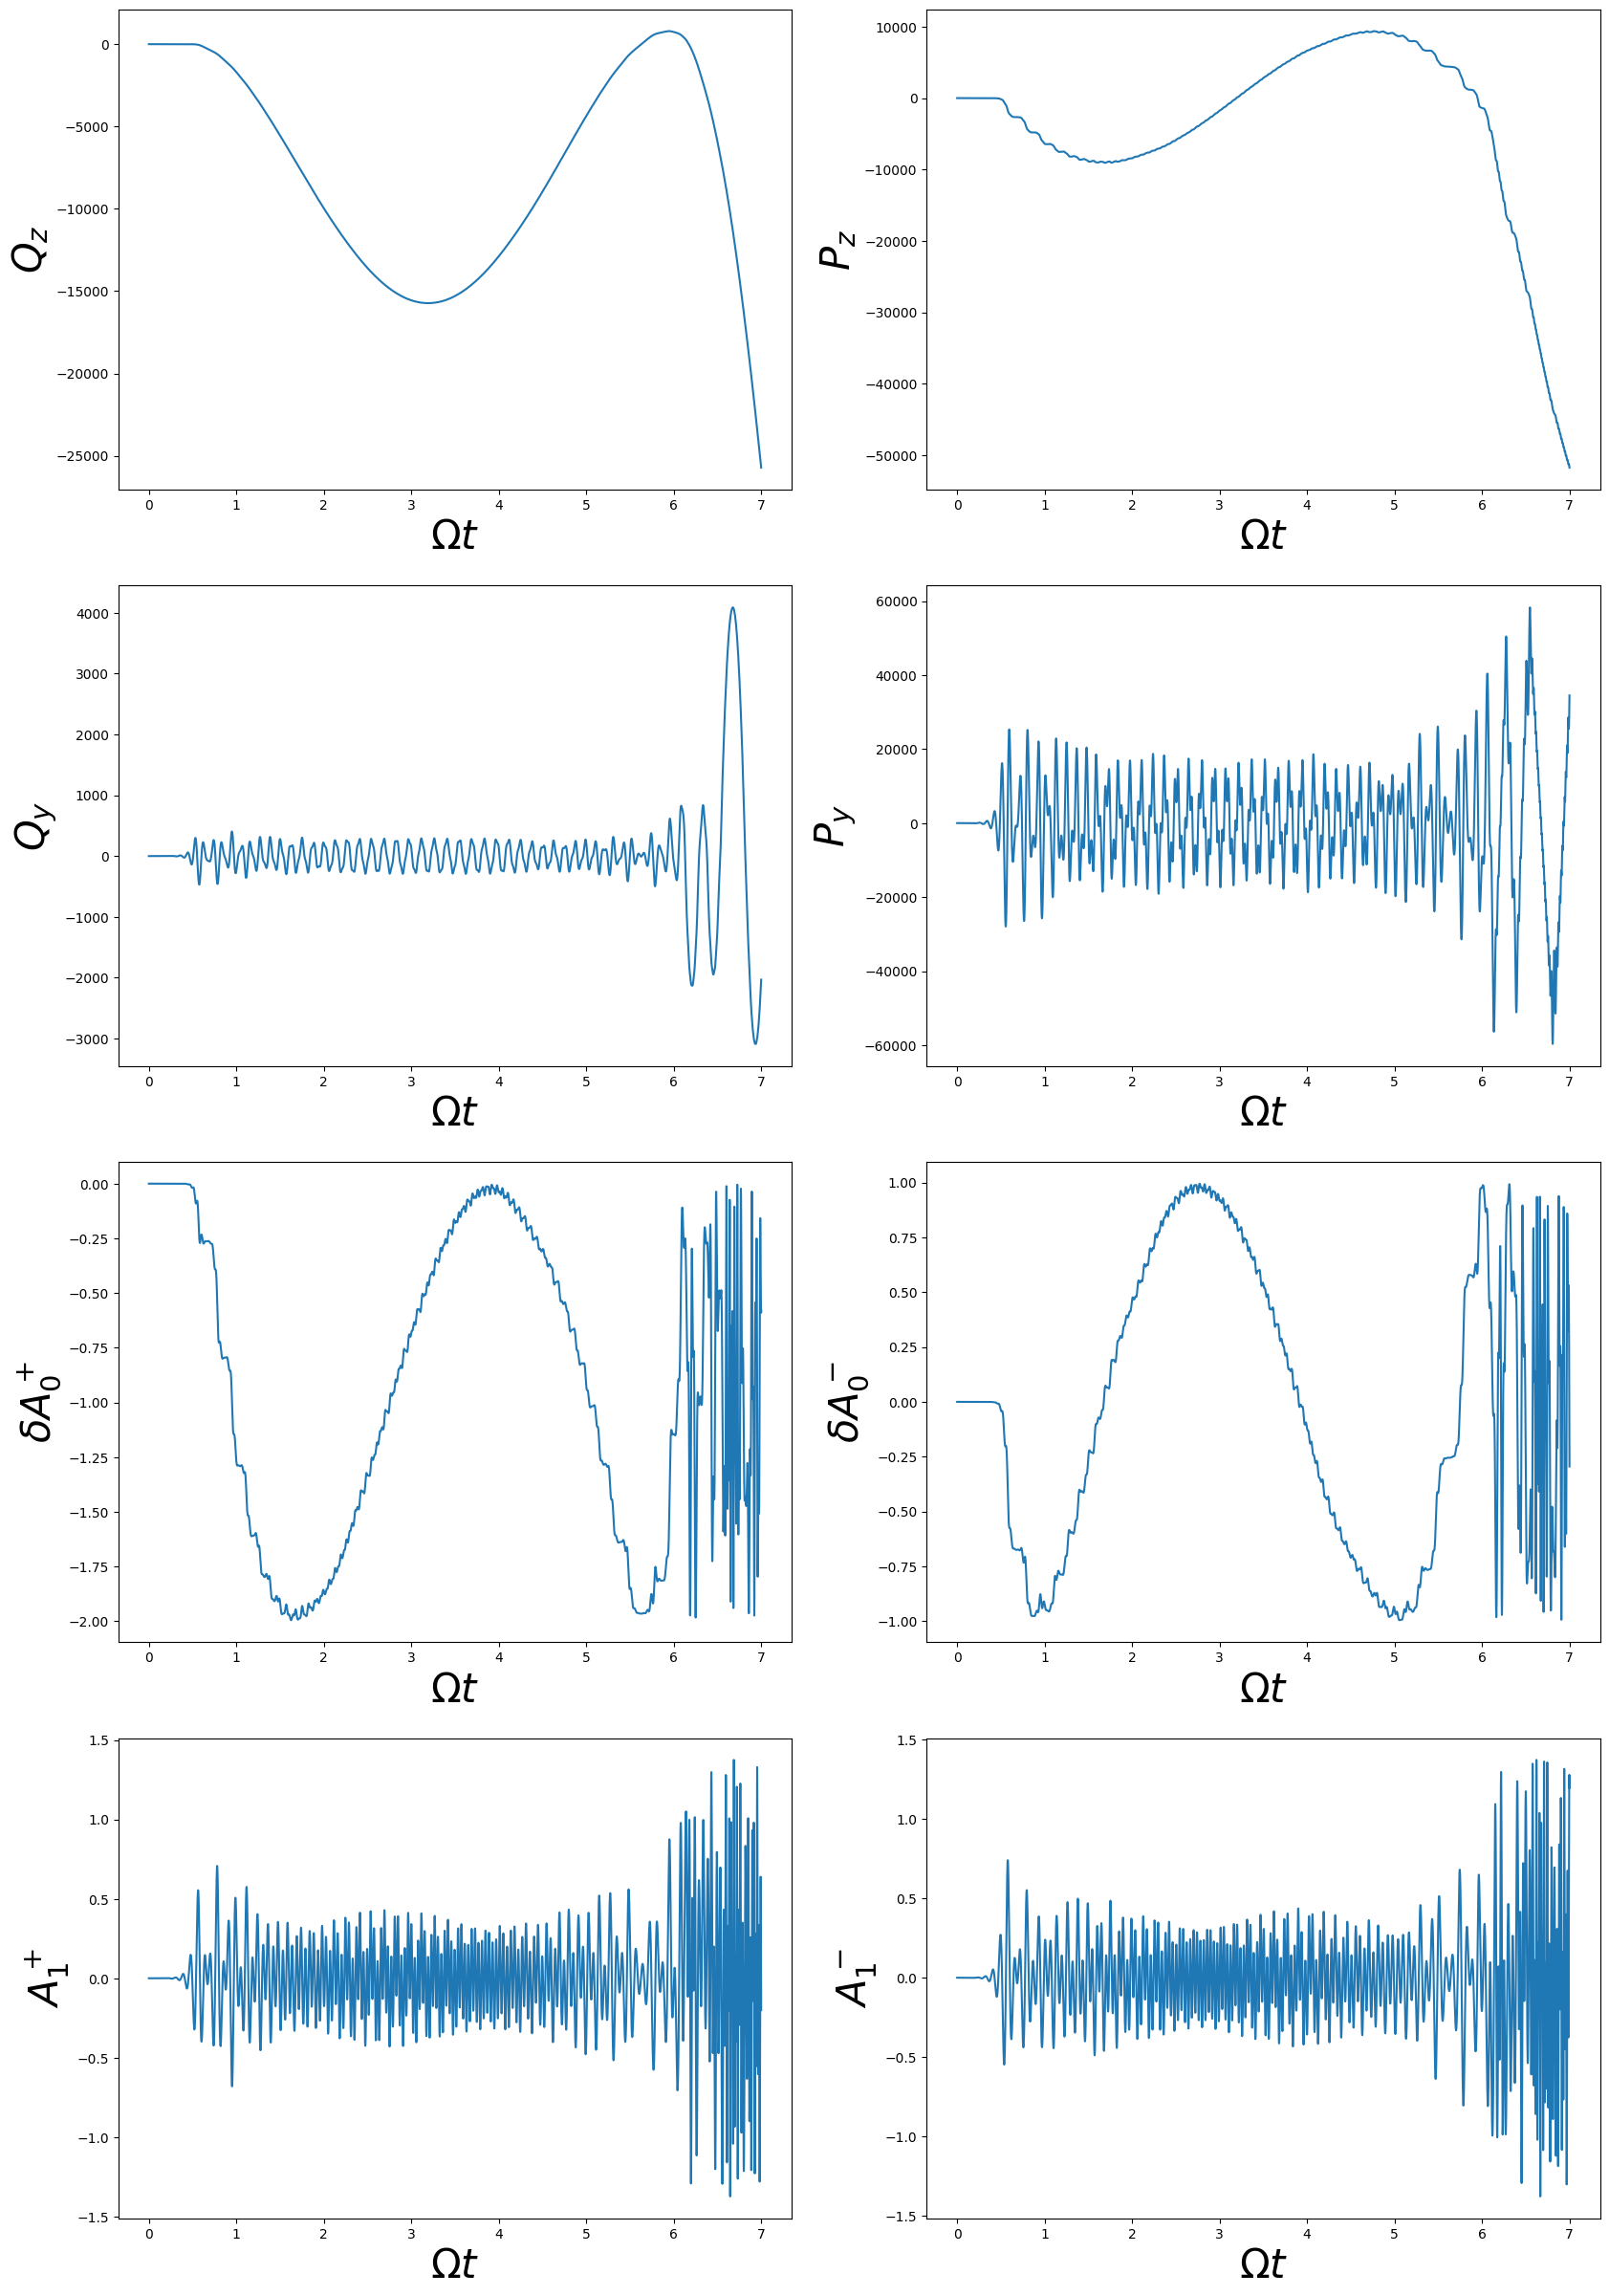

In [5]:
P_c=1.1 ############### CRITICAL parameter
g_y=1e-1
tf=7e0

file="real_chaotic_P_c={0}_g_y={1}_tf={2}_sep_energy".format(P_c,g_y,tf)

data = np.load(folder+file+".npz")
sol_c=data['sol']
t=data['t']
label_list=data['label']
print("time_taken=",data['time_taken'],"seconds")
fig, axs = plt.subplots(4, 2,figsize=(20,30))

for i in range(8):
    axs[i//2,i%2].plot(t[::1],sol_c[i][::1])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [84]:
#     def psi_ODE_v2(t,z,delta,g_y,g_z1,N0):
#         psi_1,psi_2,psi_3,psi_4,A0_p,A0_m,q_z,p_z,N=z
#         psi=np.array([psi_1,psi_2,psi_3,psi_4])
#         w=np.einsum('ij,j', U, psi)
#         q_y,p_y,A1_p,A1_m=w
#         nl=np.array([0,-2*g_y*N0*(A1_p*A0_m-A1_m*A0_p),+g_z1*q_z*A1_m-g_y*q_y*A0_p,-g_z1*q_z*A1_p-g_y*q_y*A0_m],dtype=complex)
#         psi_dot=np.einsum('ij,j', Eig, psi)+np.einsum('ij,j', U_inv, nl)

#         q_z_dot=p_z
#         p_z_dot=-q_z+2*g_z1*N0*(2*A0_p+A0_p**2+A0_m**2)

#         A0_p_dot=g_y*q_y*A1_p/2
#         A0_m_dot=g_y*q_y*A1_m/2

#         psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot=psi_dot
#         w_dot=np.einsum('ij,j', U, psi_dot)
#         q_y_dot,p_y_dot,A1_p_dot,A1_m_dot=w_dot
#         N_dot=2*A0_p_dot+2*A0_p*A0_p_dot+2*A0_m*A0_m_dot+A1_p*A1_p_dot+A1_m*A1_m_dot

#         x_list=[psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,A0_p_dot,A0_m_dot,q_z_dot,p_z_dot,N_dot]
#         return x_list


In [24]:
def mat_mul(A,B):
    C=np.zeros(4,dtype=complex)
    for i in range(4):
        C[i]=A[i][0]*B[0]+A[i][1]*B[1]+A[i][2]*B[2]+A[i][3]*B[3]        
#     print(np.linalg.norm(np.einsum("ij,j",A,B)-(A@B)))
#     print(np.einsum("ij,j",A,B)-C)
    return C

True
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   6.21284368e-13+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 1.06292752e-12+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.65661287e-10+0.00000000e+00j]
 [ 1.38777878e-17+1.38777878e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.42108547e-14+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -1.79720362e-19+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]
(1+1.1102230246251565e-16j)


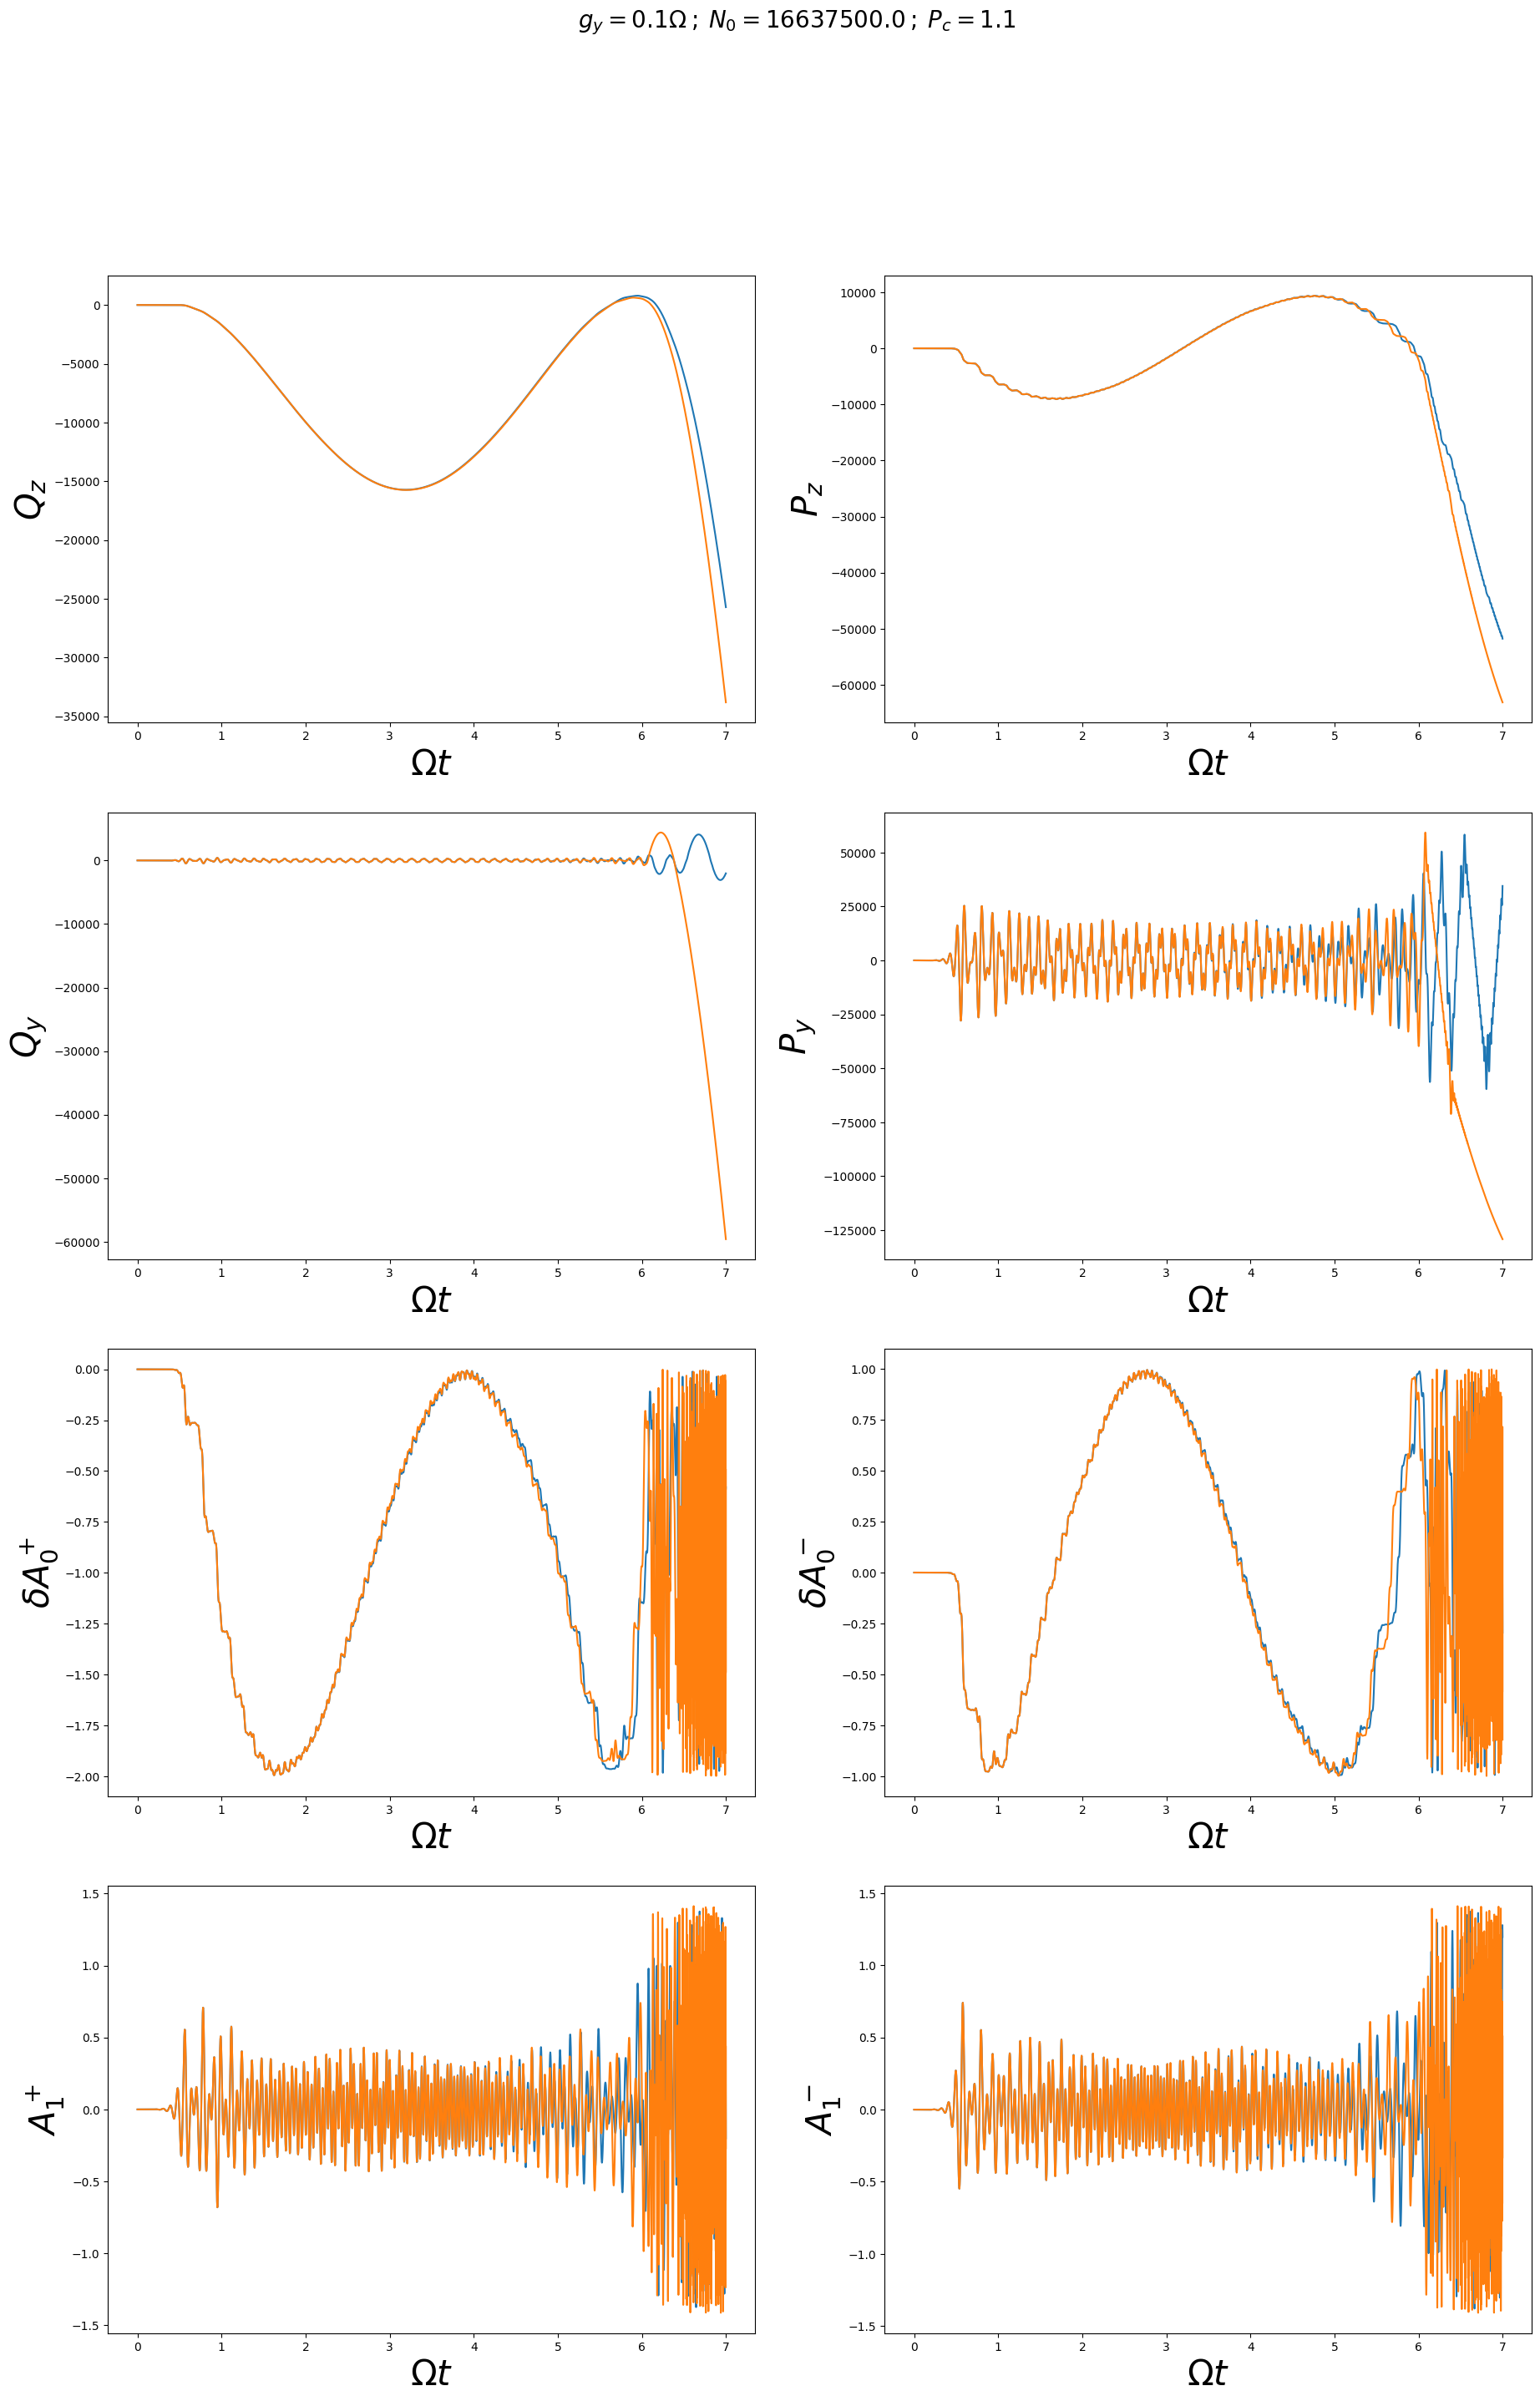

In [24]:
P_c=1.1 ############### CRITICAL parameter
g_y=1e-1
qy_0=1e-2
tf=7e0
N_step=10000

N0=(P_c*del_omega)**3/(8*g_y**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,np.round(N0),P_c)

# label_list=["$Re(\psi_1)$","$Re(\psi_2)$","$Re(\psi_3)$","$Re(\psi_4)$","$q_z$","$p_z$","$H$","$N$"]
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]



z0=np.array([1,1,-1,-1,0,0,0,0,0])*qy_0+0j ## prefactor of delta*g_y/(2*D) multiplied in other function
z0[8]=1


param_list=[del_omega,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=psi_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle(title, fontsize=20)
for i in range(8):
#     axs[i//2,i%2].plot(t,zz[i])
#     axs[i//2,i%2].plot(t,sol_c[i],t,zz[i],t,sol_c[i]-zz[i])
    axs[i//2,i%2].plot(t,sol_c[i],t,zz[i])

    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()